# Including confounders in association studies

It is known that technical factors influence gene expression. For example, time between donor death and tissue harvesting, is strongly associated to the expression of specific genes. The first principle component of the gene expression data captures this relationship.

We have generated image features from the final layer of a neural network (InceptionetV3) retrained to differentiate between tissue types. Interestingly, certain features are strongly correlated with technical variation, suggesting that this technical variation manifests in the images. The transcripts that are known to be associated with these technical factors, then have a relationship to these image features.

Are these image features associated with variation that is not purely technical? We use linear mixed models (LMMs) to answer this question. The goal is to account for known technical variation in the model, and only report unaccounted associations that are more likely to be biologically interesting.

One result of having technical factors causing so many associations is that it means that the resulting p-values are **highly inflated**. This means that we see far more significant pvalues than we expect to. For example, take the raw associations between the top 100 varying image features and the 100 most highly expressed genes along with the 100 most highly expressed transcripts.

On the RHS, we show a QQ plot, which is a graph comparing the expected number of highly associated genes to the number of strong associations we expect to see by chance.

on the LHS, we see a histogram of the p-values.

We see far more highly associated p-values than we expect.

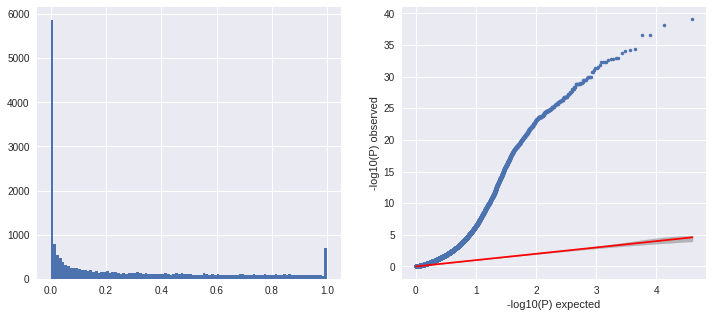

In [238]:
from limix.plot import qqplot
import warnings
warnings.filterwarnings("ignore")
most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))
pvalues = results['mean_256_pvalues'].flatten()
fig, ax = plt.subplots(1,2,figsize=(12,5))
qqplot(pvalues,alphaLevel=0.05,ax = ax[1])
ax[0].hist(pvalues,bins=100)
plt.show()

We see many more strongly associated -log10 p-values than we expect.

We can quantify the level of inflation by looking at the $\lambda$ statistic. The lambda distribution looks at the distribution of the test statistic before they are converted into p-values. The $\lambda$ value is defined as the median of the test-statistics, which are $\chi^2$, divided by the median of the $\chi^2$ distribution with one degree of freedom, which is 0.456. 

The $\lambda$ statistic is also implemented in Limix, with the following function.

In [185]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

In [186]:
estimate_lambda(pvalues)

5.0707637669115897

We see an extremely high value of $\lambda$ for these p-values. Trustworthy sets of p-values are generally close to 1. We would like to correct for this and achieve fewer globally associated p-values.

In [256]:
simulated_pvalues = np.random.random(200*100)

estimate_lambda(simulated_pvalues)

1.0384042534035078

For pvalues that are artificially simulated, we see that this lambda statistic is very close to 1.

## Linear mixed models

Linear models start simple: they assumed that a trait $Y$ can be explained entirely by a fixed relationship to a set of predictors, along with some residual error.

$$ Y = X \beta + \epsilon $$

Linear mixed models account for known variation in linear models. They do this by quantifying the variation caused by *fixed effects* and *random effects*.

$$\begin{equation} Y = X \beta + Zu + \epsilon \end{equation}$$

The $X\beta$ corresponds to the *fixed effect*, and the $Zu + \epsilon$ corresponds to the *random effect*.

There is good reason to believe this formulating a phenotype into this relationship is useful, especially when we know that there exists distinct groups within our set of predictors.

$u$ here can be thought of as a fixed value, similar to $\beta$. However, it is more commonly described as a random variable.

$$u \sim N(0,D)$$

An important point to notice, is that $u$ has mean $0$. All the fixed effects are captured in the $X\beta$ term. It is therefore important to include any group fixed effects into the $X$ matrix.

To make this clear, let us assume that trait $Y$ is modelled as the sum of a fixed and random effect, as before. Let us in addition assume that the group membership of a specific data point causes a a fixed effect on the mean. 


$$ Y = X\beta + Z\gamma + Zu $$

$\gamma$ is a vector of coefficients which quantifies the fixed effect of being in a specific group. The information that encodes which group a certain data point came from, is given by the design matrix $Z$.

This can be formulated in the following way:


$$ Y = \begin{pmatrix}X & Z\end{pmatrix} \begin{pmatrix}\beta \\ \gamma\end{pmatrix} + Zu$$

i.e. 

$$ Y = X^*\beta^* + Zu$$

For some other $X^*$ and $\beta^*$. This is the same formulation as before, if we remember to include group membership in our set of predictors.


Since $u$ is a random variable, we don't actually estimate it. We estimate the variance covariance matrix $D$.

Finally, we need to estimate the residual term, $\epsilon$.
 
$$\epsilon \sim N(0,R) $$

In our specific case, we want to quantify the variation of our image features outside of known technical factors. As such, we treat these factors as **fixed effects**. Fixed-effects are commonly used to capture the effect of being in a group, whereas random effect capture the effect of repeated trials from a single individual. Right now, we do not have any repeated measures, so we do not include random effects.

LMM are already included in limix - a package developed by the Stegle group at the EBI which implements well known models from statistical genetics. Specifically, it is included as `limix.qtl.qtl_test_lmm`. This function takes in as parameters the snps matrix and phenotype vector, as well as optional parameters specifying the covariance structure of the data that we want to include as fixed effects. In our data, we have a matrix of gene expression values, but this can be inputted into limix without a problem. 

## Plan

We want to choose the best way to account for this technical variation. How do we do this? First we choose two methods:

- Include our 4 known technical factors as random / fixed effects.
- Include the first 5 PCs as random / fixed effects.

How do we decide which is the best method? We'll do this by measuring the inflation parameter $\lambda$. This parameter is defined as the median of of the distribution of the raw test statistics, and the median of a $\chi^2$ distribution with 1 degree of freedom. The closer this number is to 1, the more technical variation has been removed from the model.

## Specifying the technical covariates

To specify the technical covariates, we mine the phenotype data.

In [35]:
import pickle
import pandas as pd
import gzip
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

# import pandas as pd
# df = pickle.load(open(GTEx_directory + '/data/phenotype_pandas_dataframe.py','rb'))

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]

SMTSISCH = np.log(np.array(lung_df['SMTSISCH']).astype(np.float32))
SMTSISCH = SMTSISCH[phenotype_idx]
SMRIN = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMRIN']) ])
SMRIN = SMRIN[phenotype_idx]
SMEXNCRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMEXNCRT']) ])
SMEXNCRT = SMEXNCRT[phenotype_idx]
SMNTRNRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMNTRNRT']) ])
SMNTRNRT = SMNTRNRT[phenotype_idx]
raw_technical_covariates = np.array([SMTSISCH,SMRIN,SMEXNCRT,SMNTRNRT]).T

In [206]:
technical_idx = np.sum(raw_technical_covariates > 0, axis=1) == 4

These acronyms, SMTSISCH, SMRIN, SMEXNCRT, and SMNTRNRT mean:
- Time between tissue death and harvesting
- RIN number (RNA degradation)
- Exon mapping number
- Intro mapping number

Respectively. They can directly be added into lmm as covariates.

Now we load in all the precomputed features

In [1]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import seaborn
import pickle
import pandas

import h5py
mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = expression[:,most_varying_feature_idx]

In [410]:
expression.shape

(274, 28683)

In [418]:
expression_IDs.shape

(28683,)

(200,)

We take the top 100 most variable image features, along with the top 100 transcripts with highest mean expression and the 100 transcript with the highest variance

In [207]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)


We then take the indexes for which we have technical covariate data. Technical factors for which there is missing data are given the value 0 - however this is treated as a 0 value in the analysis, and causes a problem. 231 out of 274 of the samples have all of the technical factor information.

In [211]:
filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


In [212]:
from limix.qtl import qtl_test_lmm
feature = 0
single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float))

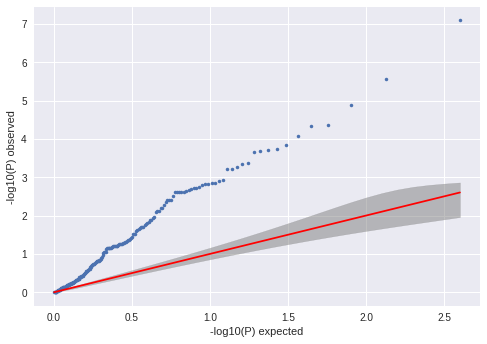

In [213]:
from limix.plot import qqplot
lim_pvalues = res.getPv().flatten()
qqplot(lim_pvalues)

Even using lim, we see that our p-values are less inflated. Indeed, we can look at our $\lambda$ statistic.

In [214]:
estimate_lambda(lim_pvalues)

4.9437715861936482

This $\lambda$ statistics is still extremely high. Most papers report a $\lambda$ statistic of closer to 1, so we still have some work to do.

## Including technical variation in the limix model.

### Random effects

Here I include the random effects in the limix `cov` parameter.

4.7497470125809143

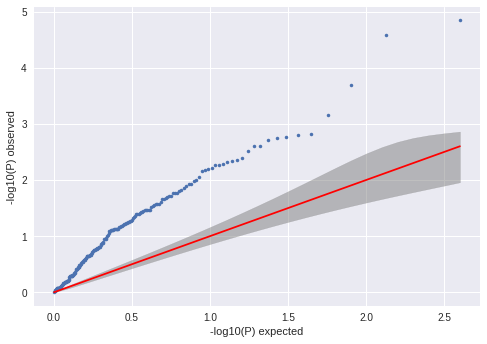

In [215]:
from limix.qtl import qtl_test_lmm
feature = 0
single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float),covs=raw_technical_covariates)
pvalues = res.getPv()
from limix.plot import qqplot
lim_pvalues = res.getPv().flatten()
qqplot(lim_pvalues)
estimate_lambda(lim_pvalues)

Here we see a reduction in the $\lambda$ value, but not by much. It is also much high than 1.

## Including top 5 PCs as covariates

If we include the technical covariates in the model, we still see a high level of inflation. What about if we include the first 5 PCs?

2.52788983311


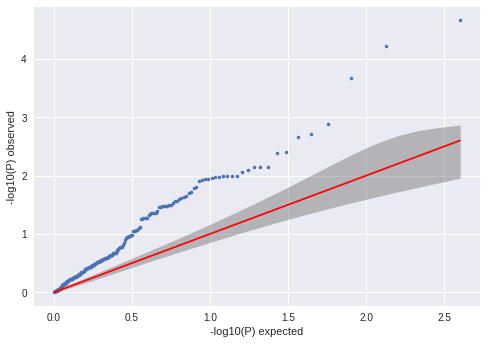

In [217]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 5
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This seems to account for some of the variation that exists.

What about for the first 15 PCs?

1.60345256528


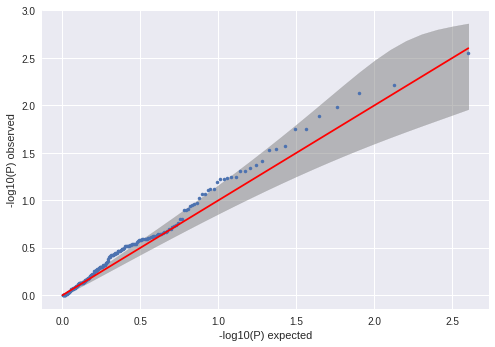

In [218]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 15
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This now seems to be removing all the noticable inflation including the signal.

How does the lambda value vary as a function of number of PCs we include?

In [219]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

lambdas = []
for k in range(1,20):
    feature = 0
    pca = PCA(n_components=k)
    pca_transform = pca.fit_transform(filt_expression)
    pca_transform.shape
    test_cov = np.ones(shape=(274,k + 1))
    
    test_cov[:,1:] = pca_transform

    single_feature = filt_features[:,feature].copy()
    res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
    pvalues = res.getPv()

    lim_pvalues = res.getPv().flatten()
    lamb = estimate_lambda(lim_pvalues)
    lambdas.append(lamb)

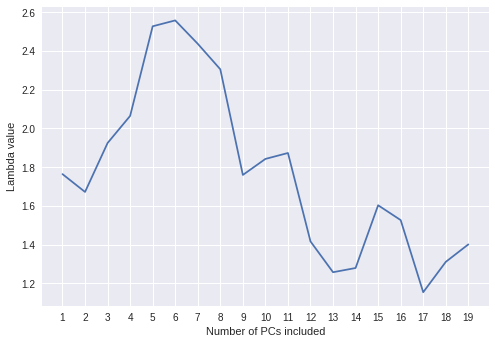

In [220]:
plt.plot(range(1,20),lambdas)
plt.xticks(range(1,20),range(1,20))
plt.xlabel("Number of PCs included")
plt.ylabel("Lambda value")
plt.show()

Interestingly, there seems to be a maximum at 5 PCs.

What about using the first two PCs?

1.67222500007


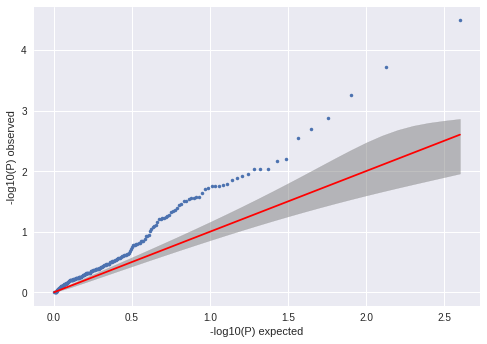

In [221]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 2
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This is a low value of $\lambda$, given the values of lambda that we have seen. But there is still are high level of overall inflation.

## Including as fixed effects

It might be better to just include these factors as fixed effects, and to build the models one SNP at a time.

Before, we are have been asking whether a specific transcript $T$ is significantly associated to a phenotype $Y$ across $n$ samples. Now let's assume that we have $t$ covariates. If we model:

$$ Y = X\beta $$

where $X$ is a matrix of size $n \times (t + 1) $, containing the $t$ technical covariates, and with the final column as the transcript expression values. $\beta$ is a $1 \times (t + 1)$ vector. The first $t$ entries of $\beta$ would be the effect sizes on the phenotype from each of the technical covariates. The final element of $\beta$ would be the effect size of that specific SNP on the phenotype, having already taken into account the technical variation.

$\beta$ can be estimated with linear regression.



In [277]:
filt_raw_technical_covariates = raw_technical_covariates[technical_idx,:]

First, we need to extend sklearn's Linear Regression to return the p-values estimates. This is taken from [here](https://gist.github.com/brentp/5355925).

In [300]:
import pdb

In [307]:
from sklearn import linear_model
from scipy import stats
import numpy as np


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])

        se = np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [311]:
def calculate_association(t,y):
    X = np.zeros(shape=(filt_raw_technical_covariates.shape[0],filt_raw_technical_covariates.shape[1] + 1))
    X[:,0:4] = filt_raw_technical_covariates
    X[:,-1] = filt_tech_expression[:,t]
    lr = LinearRegression()
    res = lr.fit(X, filt_tech_features[:,y])
    return res


In [322]:
filt_tech_features.shape

(231, 100)

We calculate the pvalue for each of these transcripts, taking into account the known technical variation.

In [ ]:
results = {}
for t in range(200):
    print ("transcript",t)
    for y in range(100):
        results['{}-{}'.format(t,y)] = calculate_association(t,y)

transcript 0
transcript 1
transcript 2
transcript 3
transcript 4
transcript 5
transcript 6
transcript 7
transcript 8
transcript 9
transcript 10
transcript 11
transcript 12
transcript 13
transcript 14
transcript 15
transcript 16
transcript 17
transcript 18
transcript 19
transcript 20
transcript 21
transcript 22
transcript 23
transcript 24


In [346]:
pvalues = []
betas = []
for t in range(200):
    for y in range(100):
        pvalues.append(results['{}-{}'.format(t,y)].p[-1])
        betas.append(results['{}-{}'.format(t,y)].coef_[-1])

The betas seem to be normally distributed.

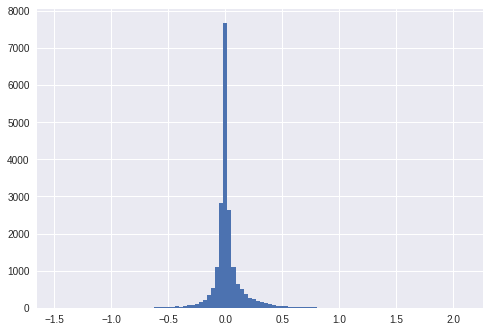

In [349]:
plt.hist(betas,bins=100)
plt.show()

But the pvalues still seem to be inflated

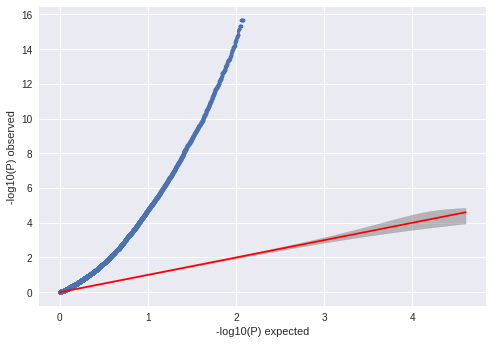

In [334]:
qqplot(np.array(pvalues))

Are there very small p-values with large large effect sizes?

Yes there are, and there seems to be factors which are independent of the technical effects I have included.

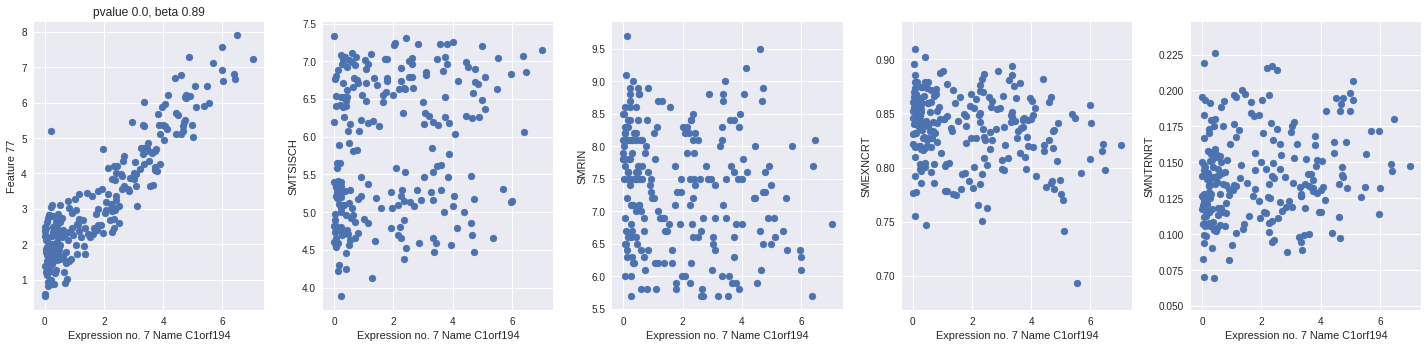

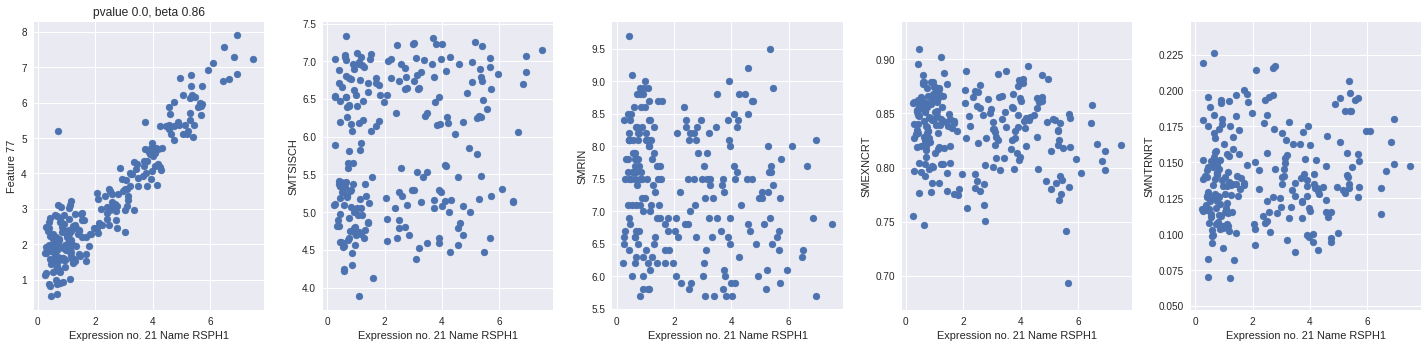

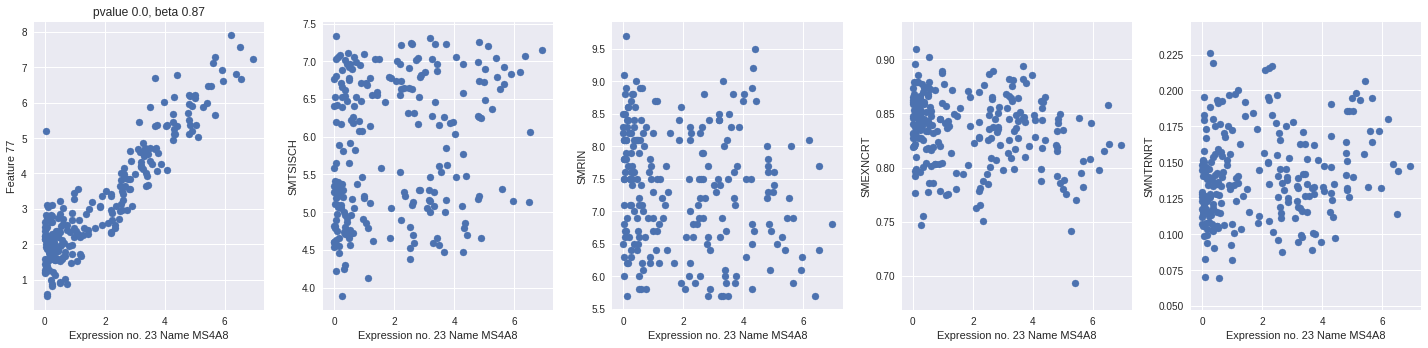

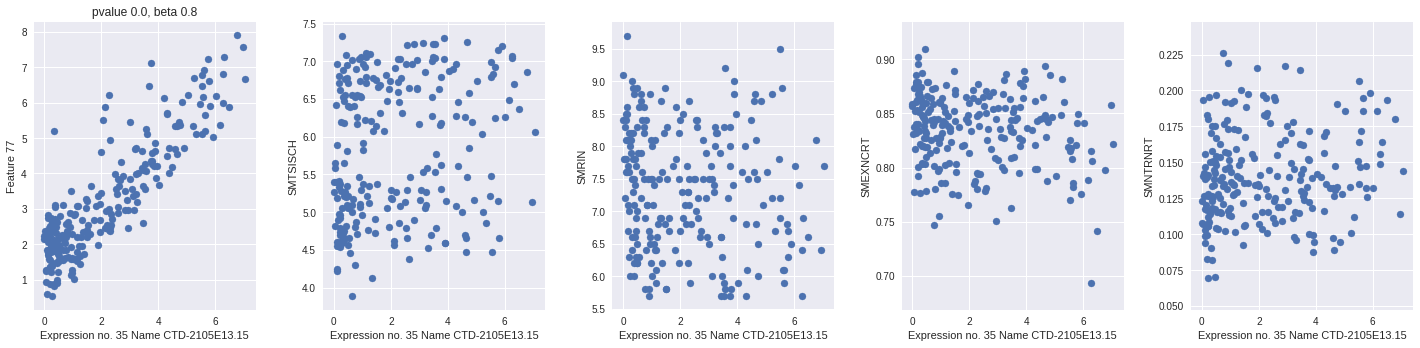

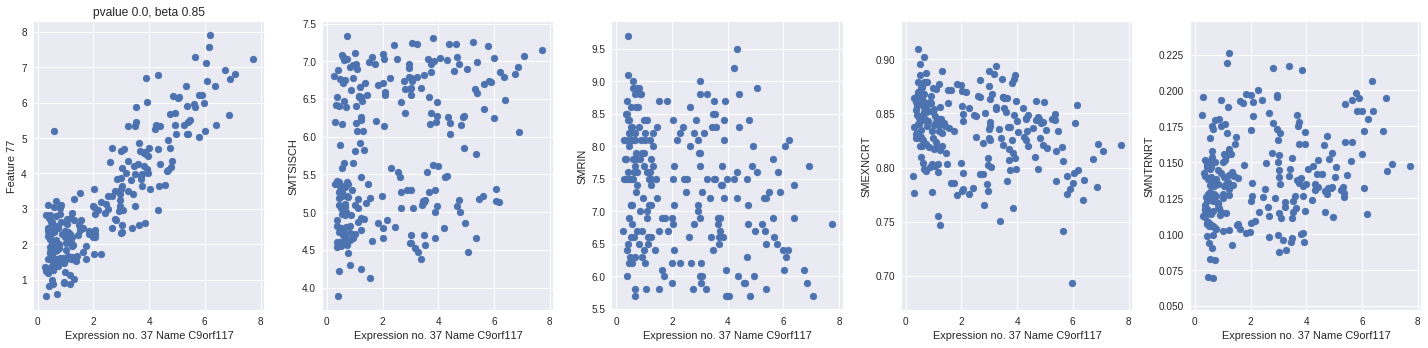

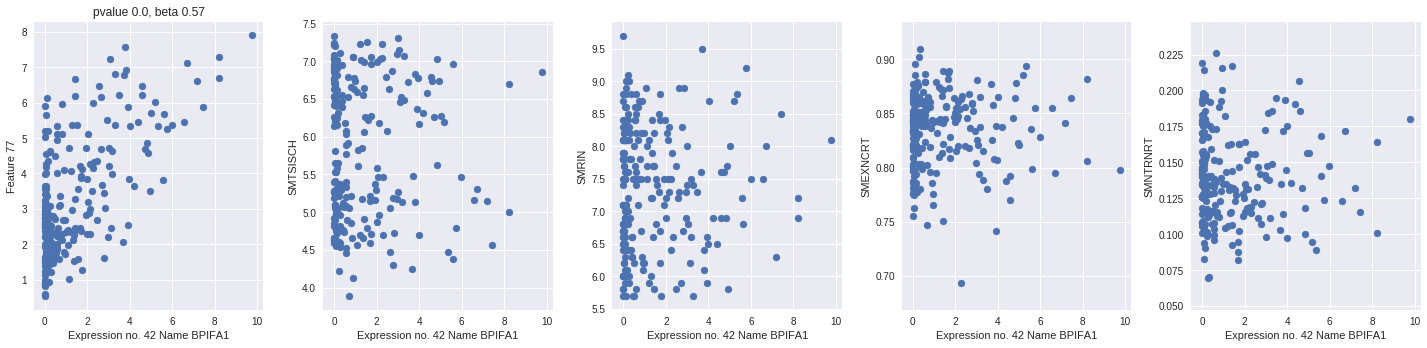

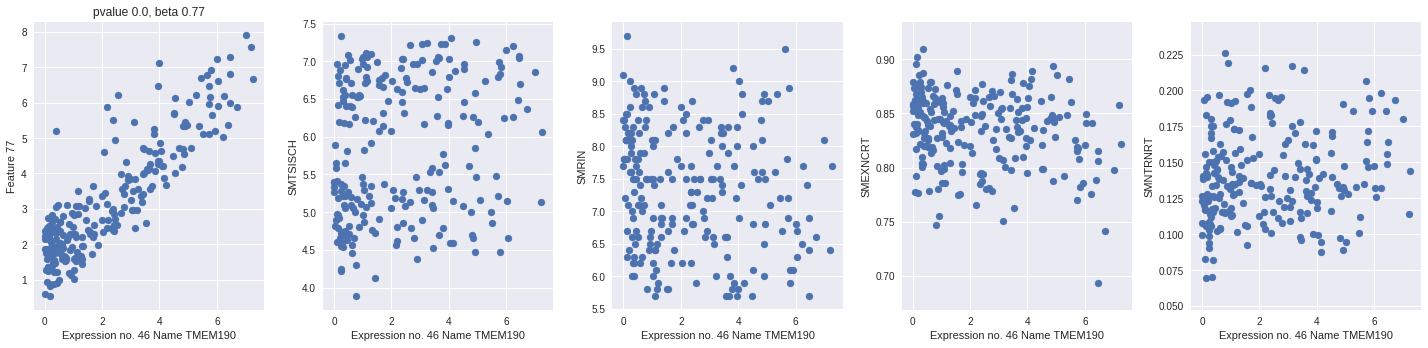

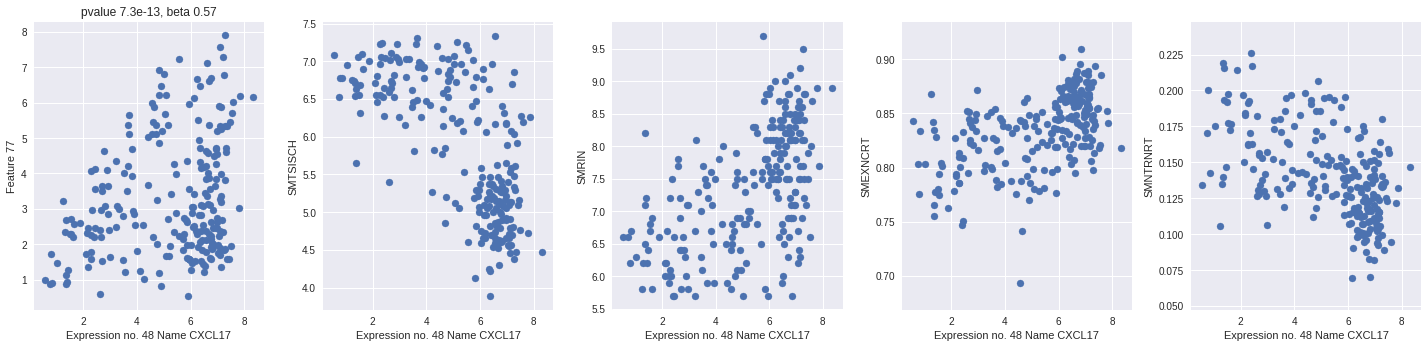

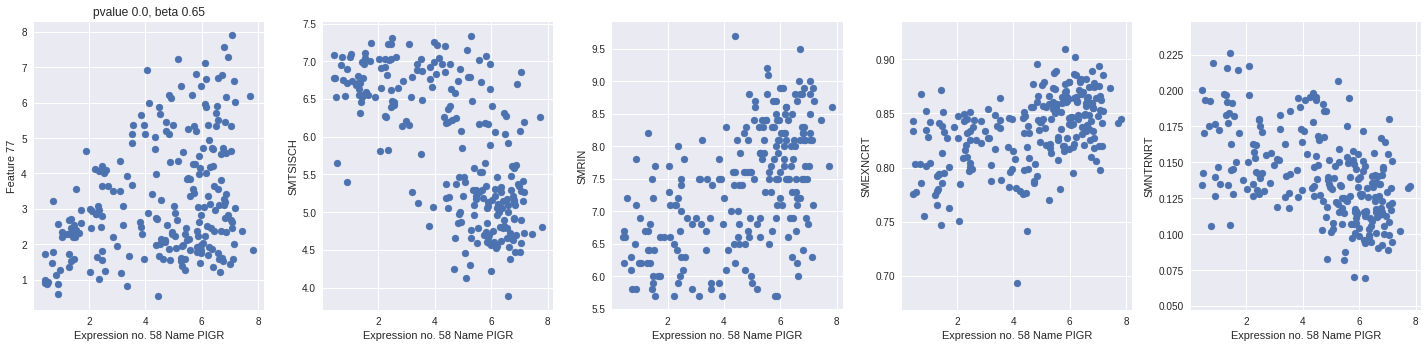

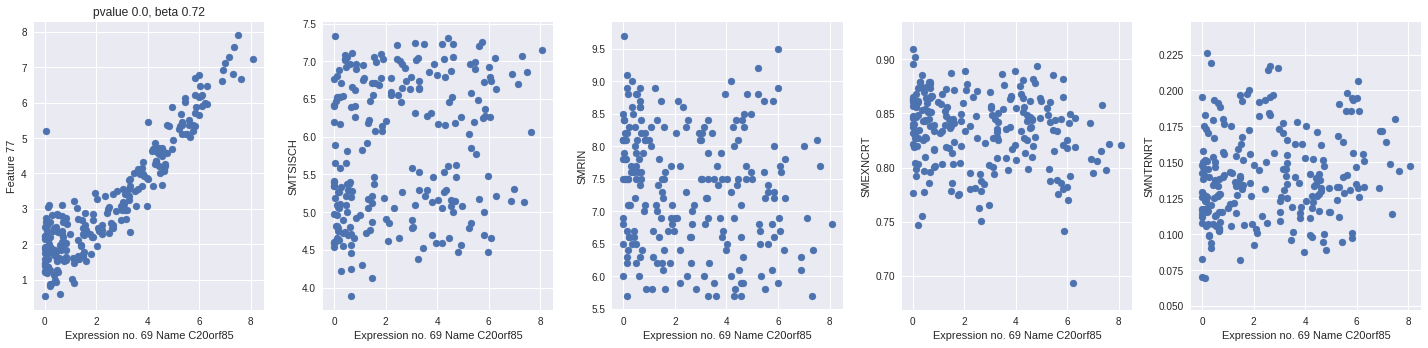

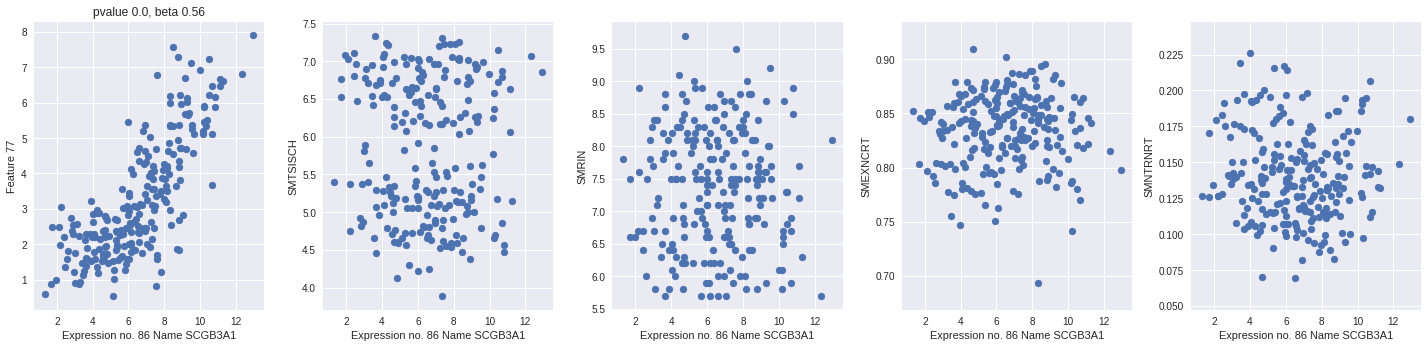

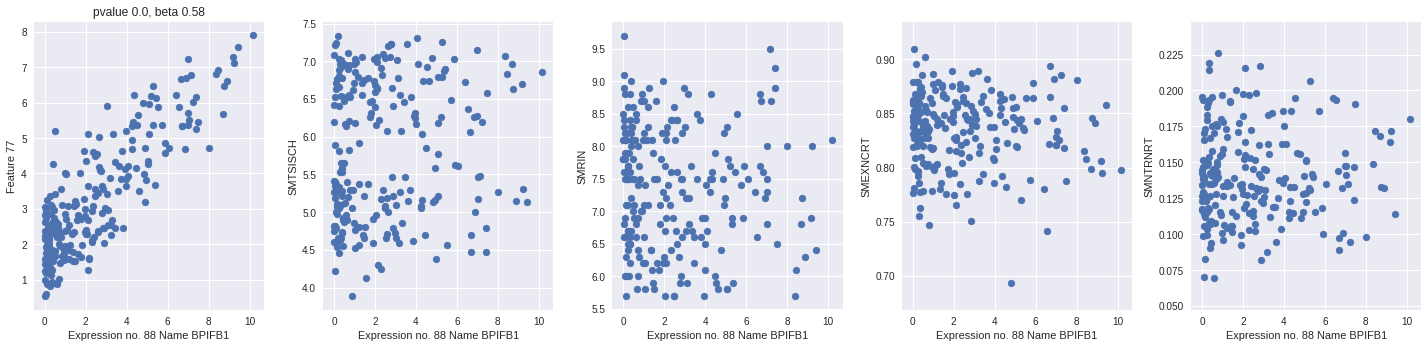

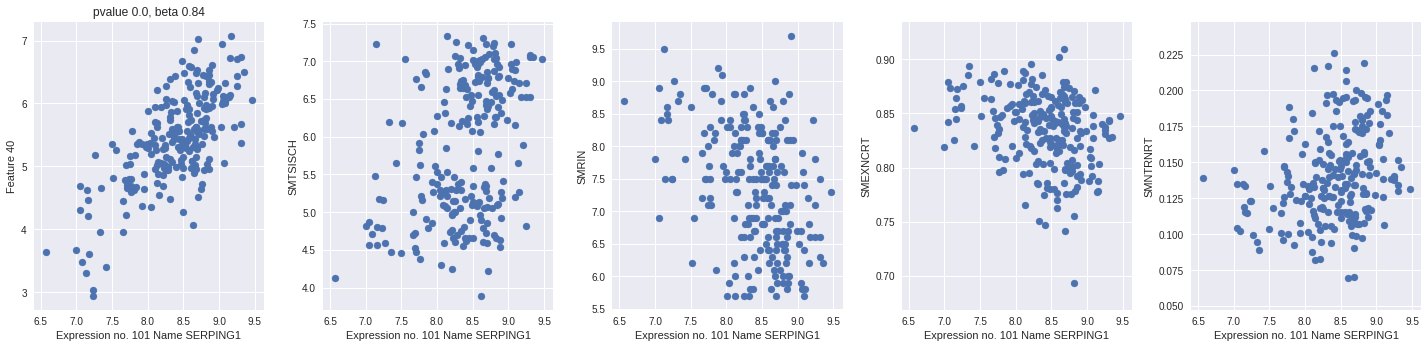

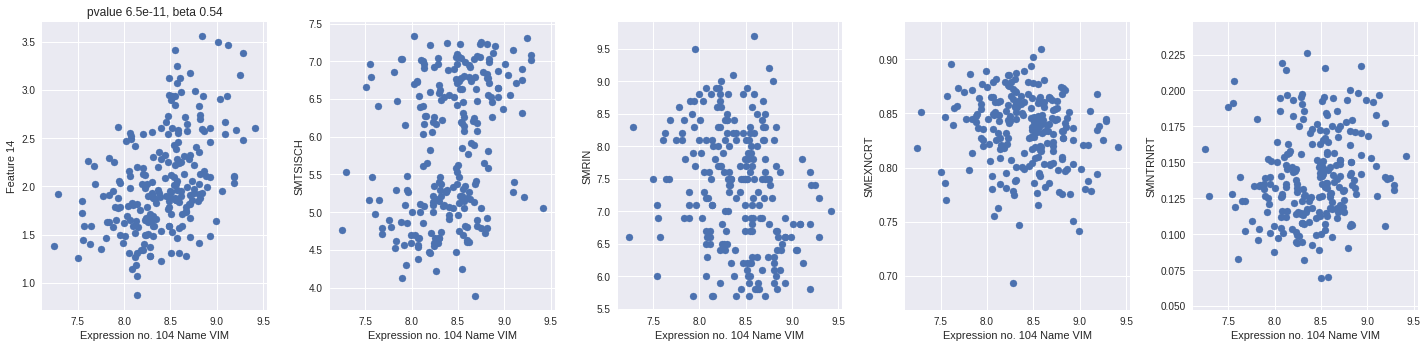

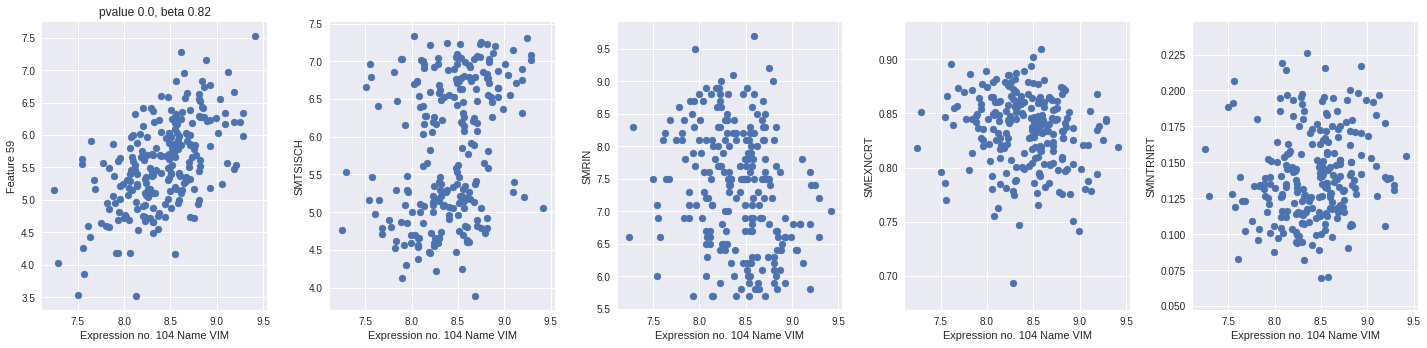

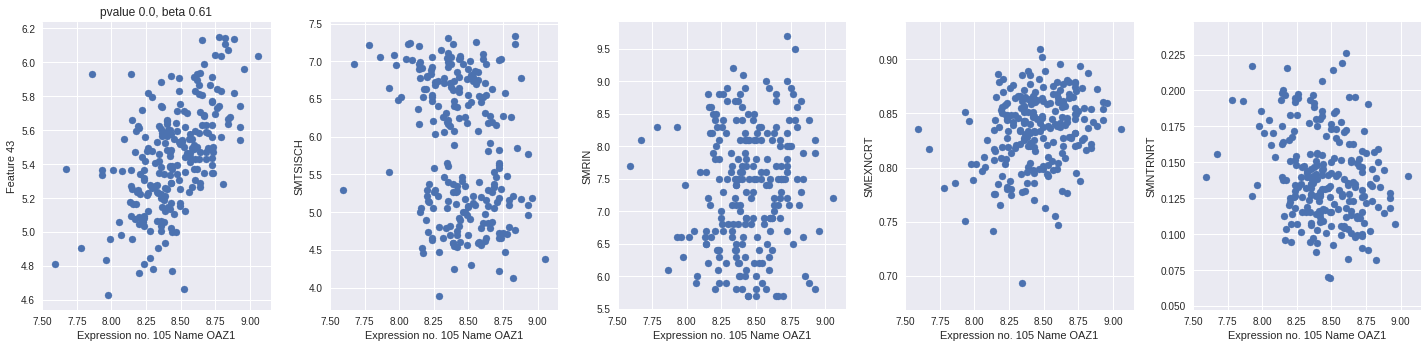

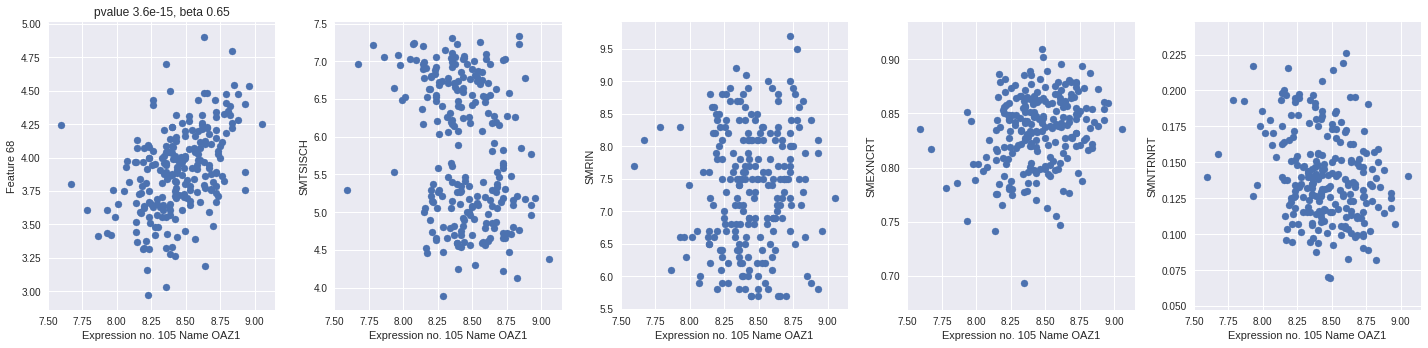

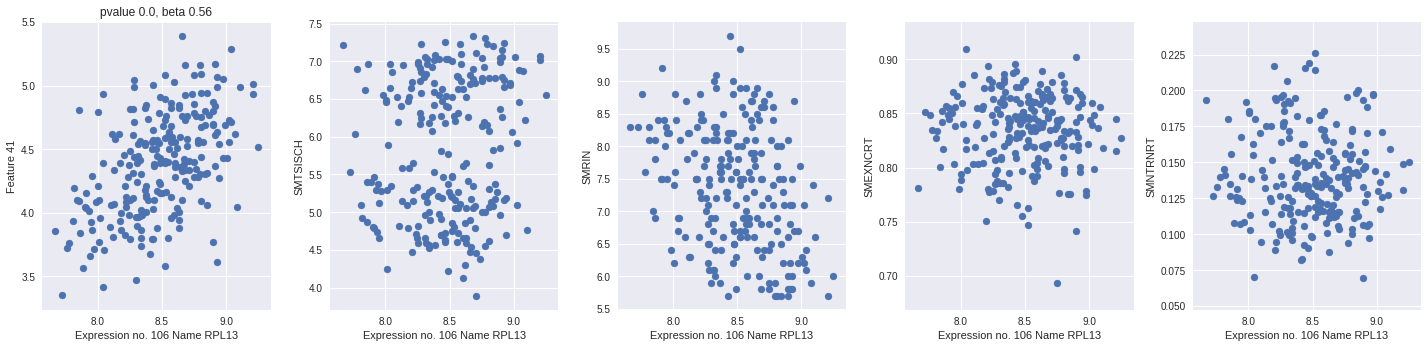

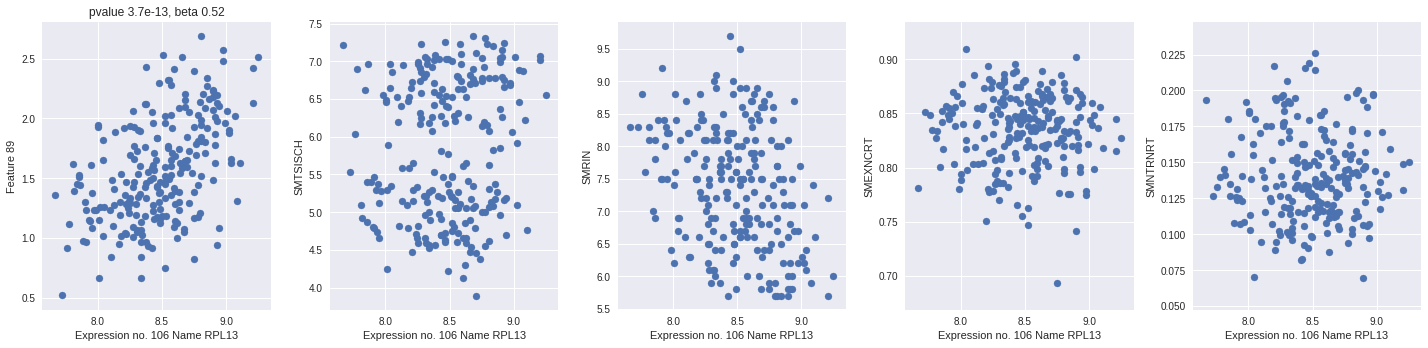

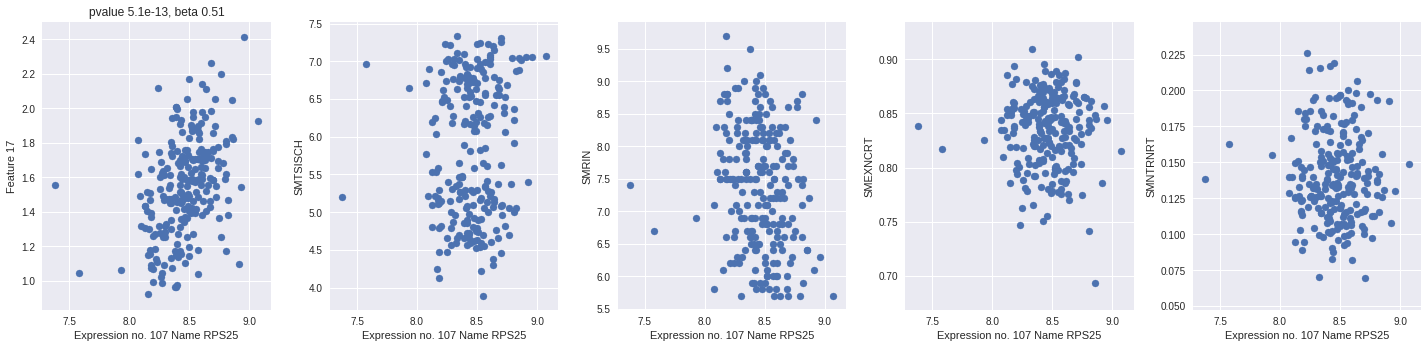

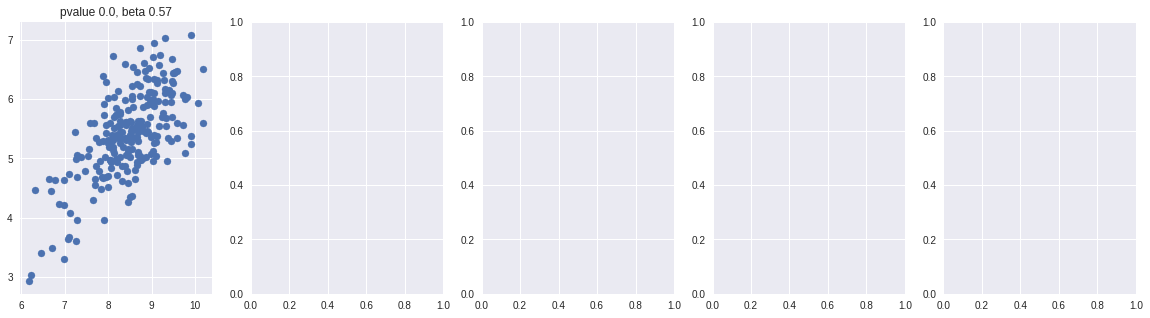

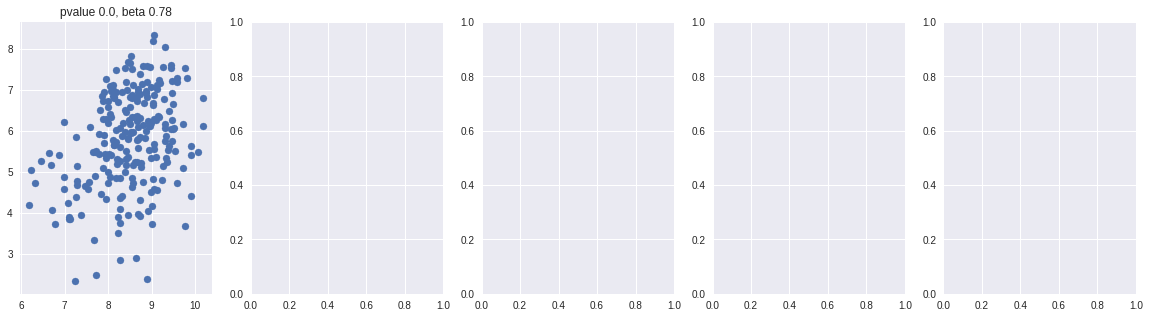

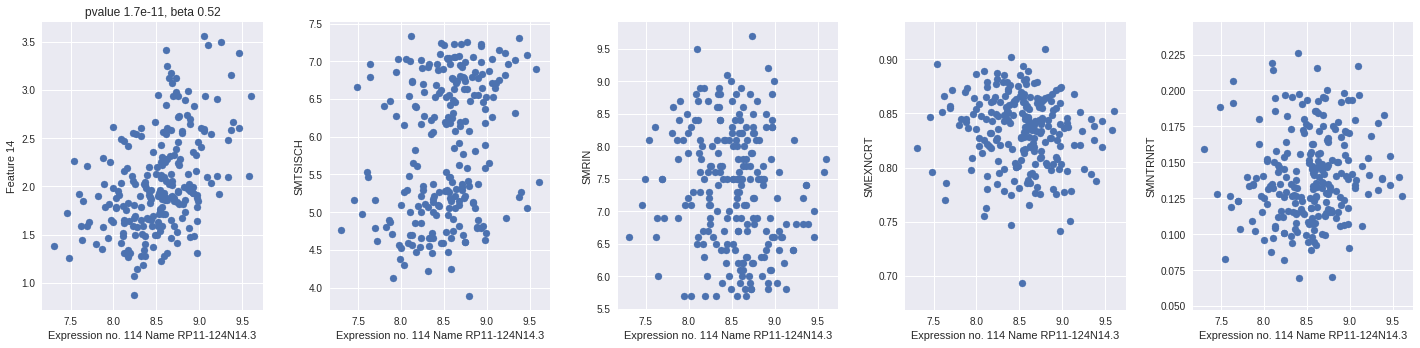

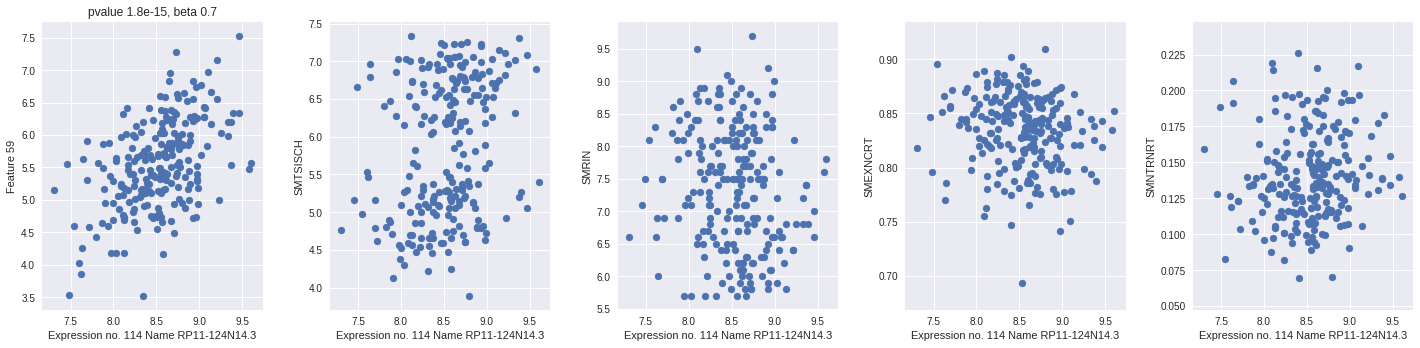

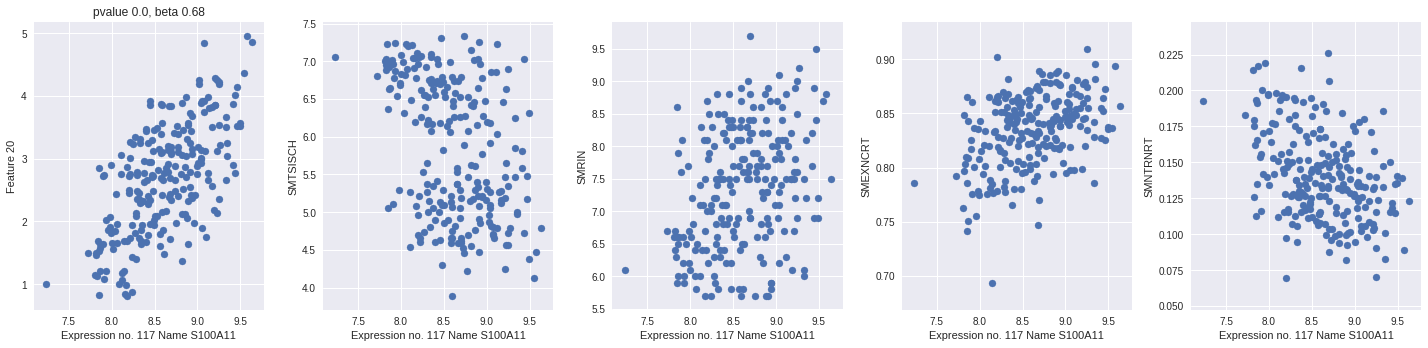

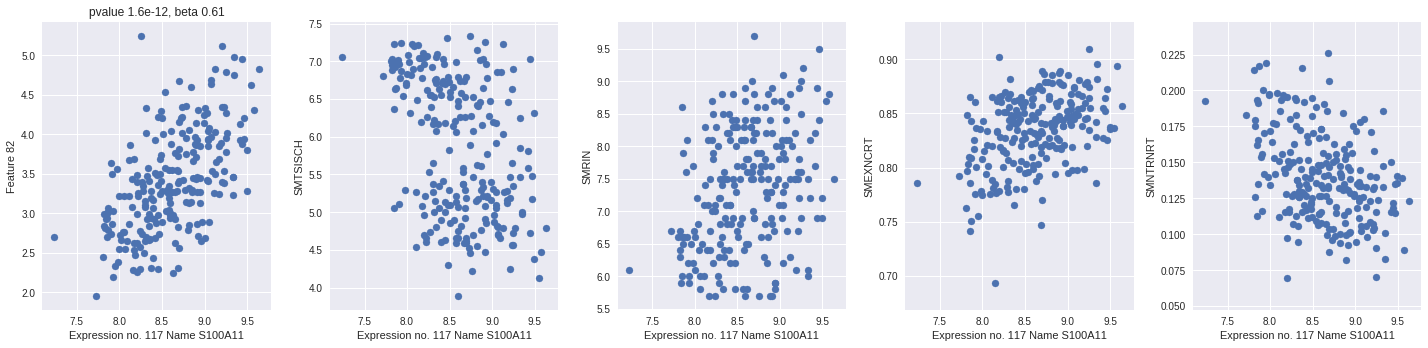

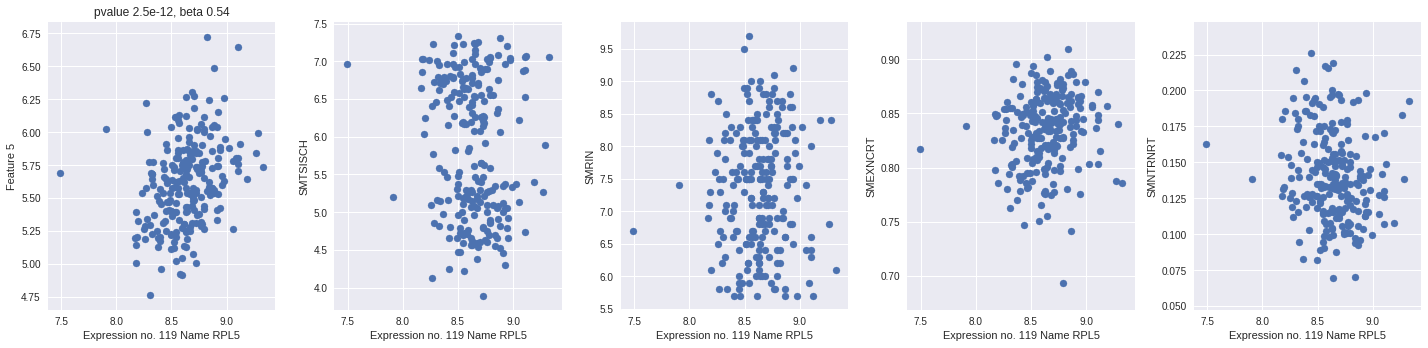

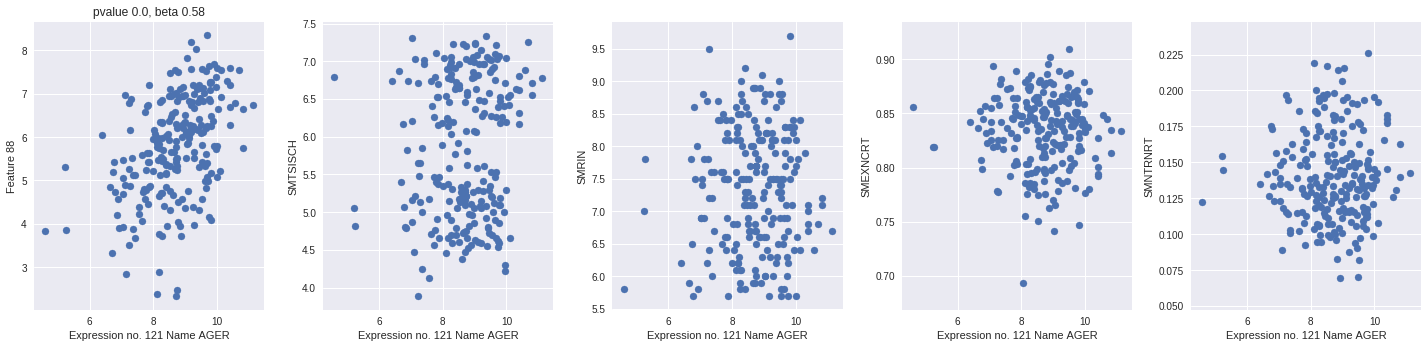

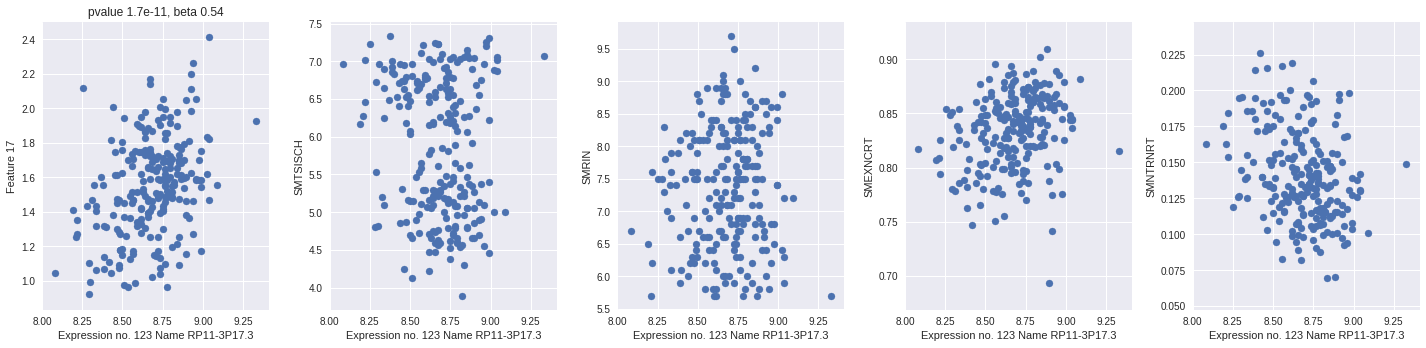

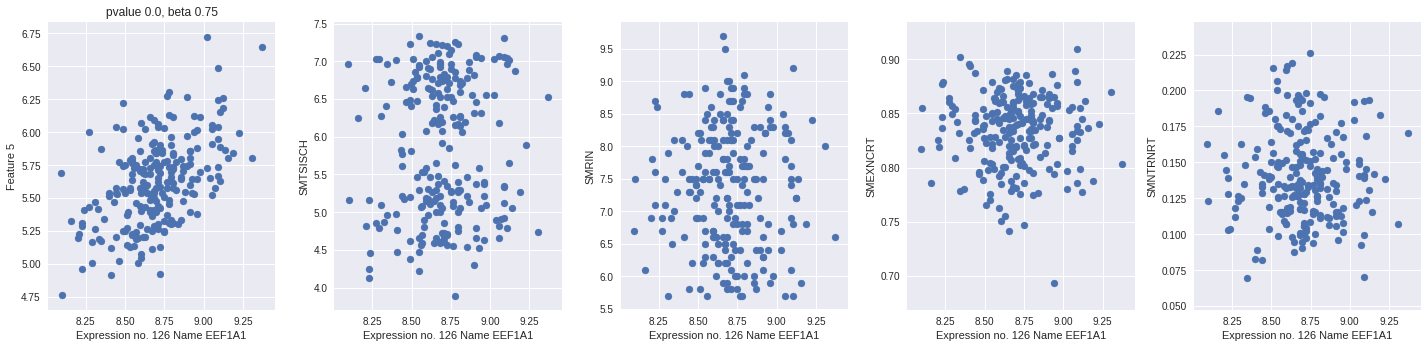

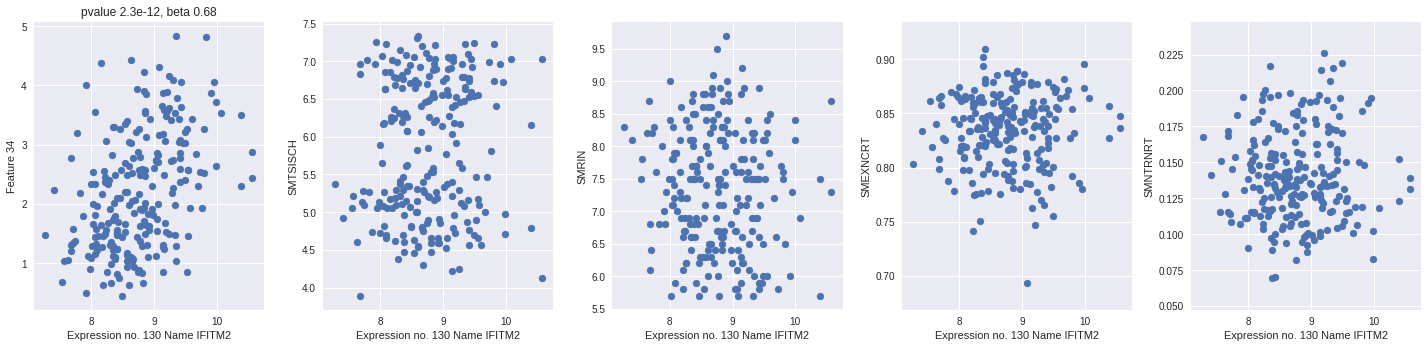

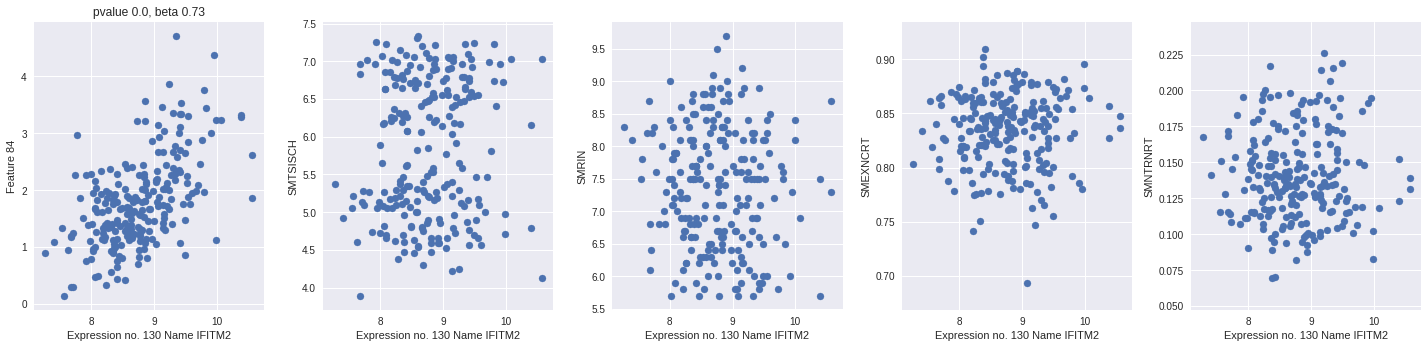

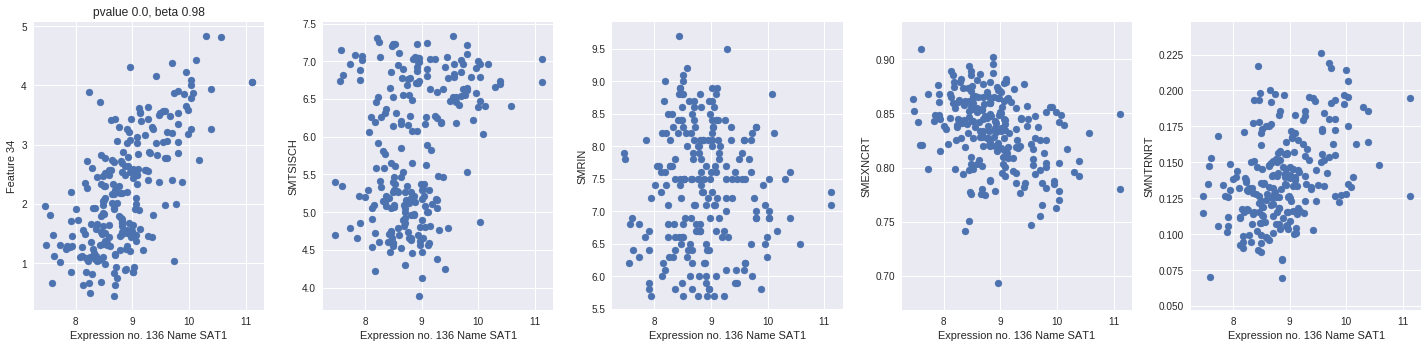

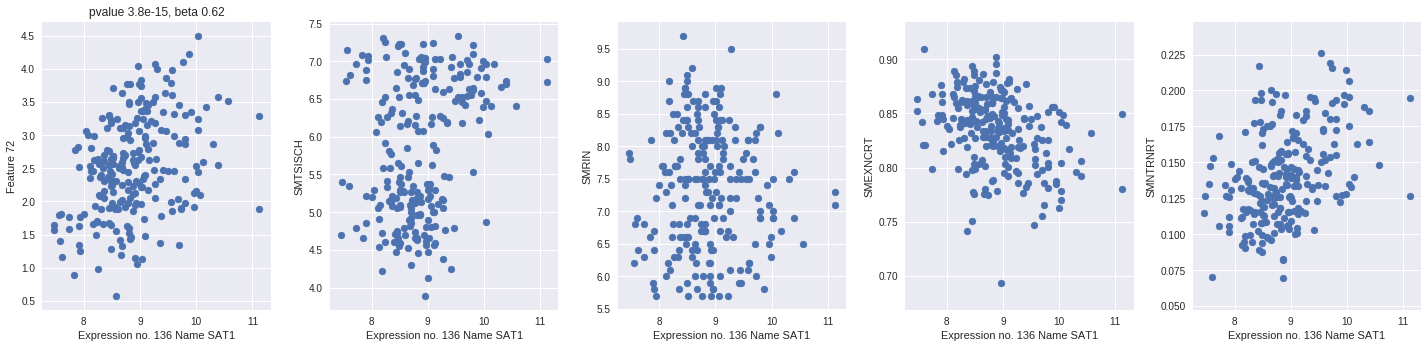

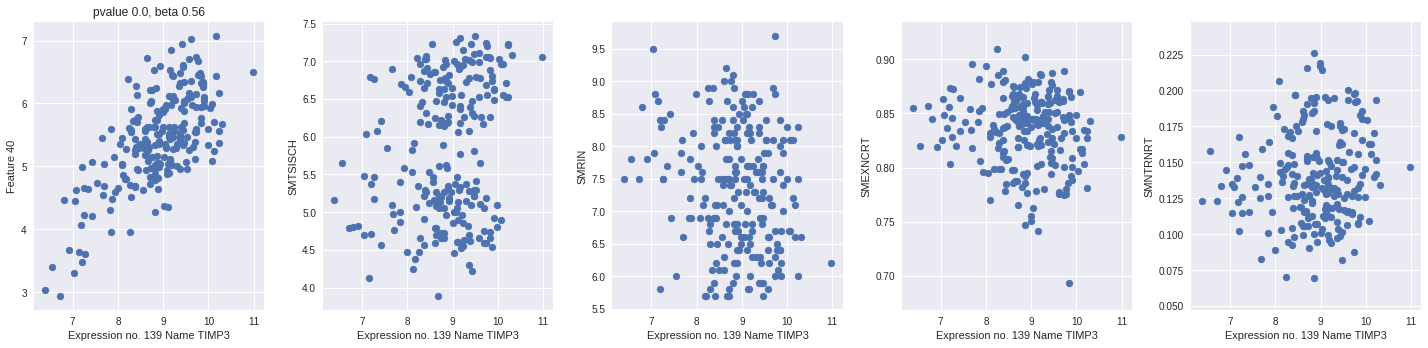

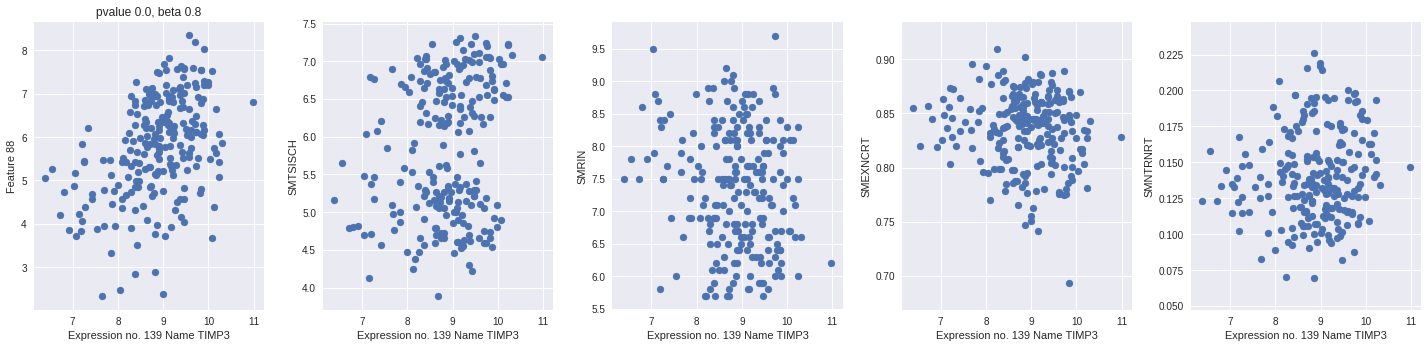

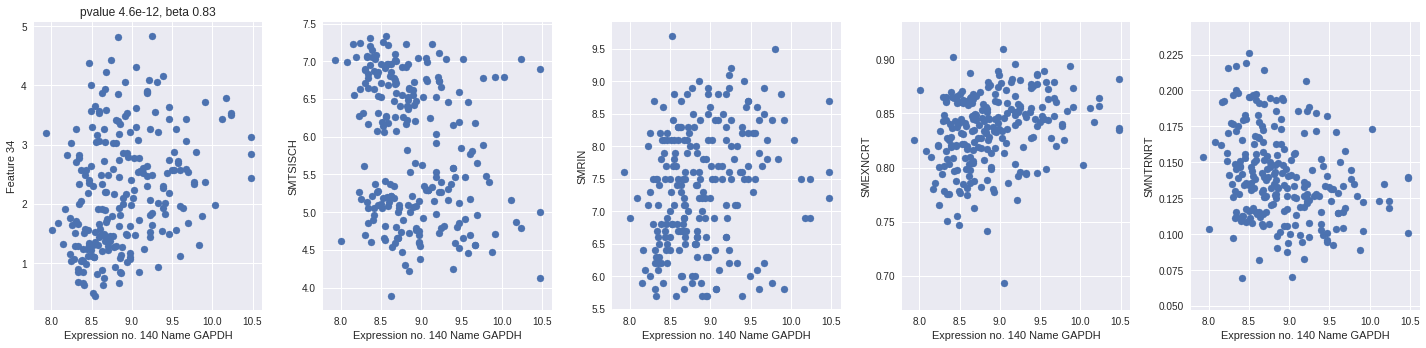

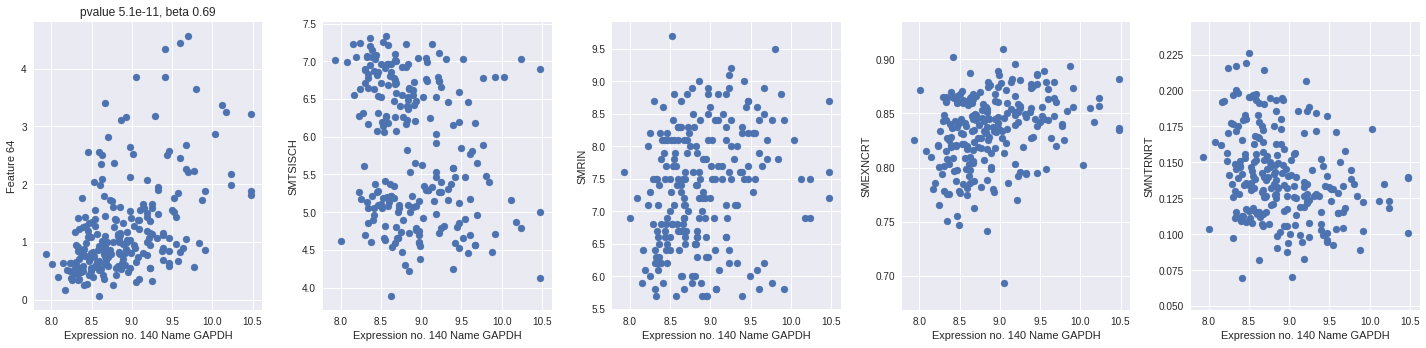

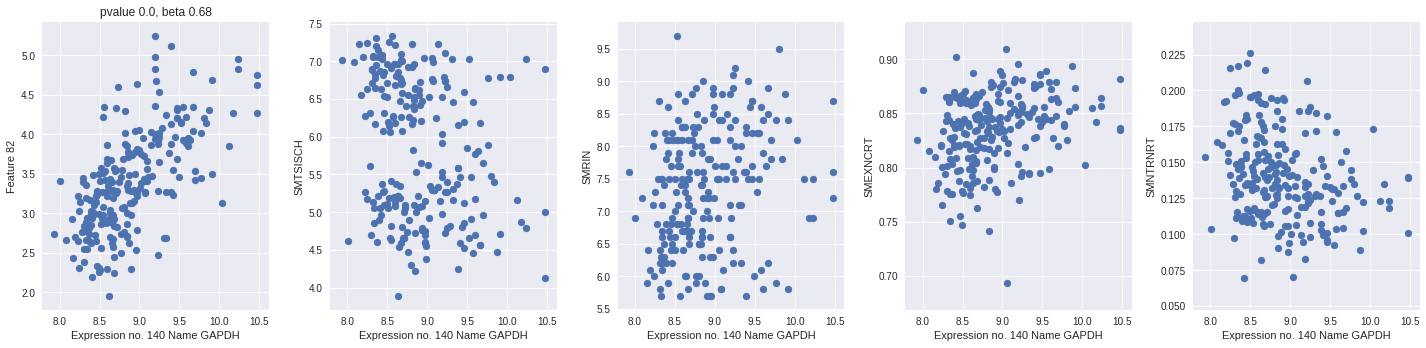

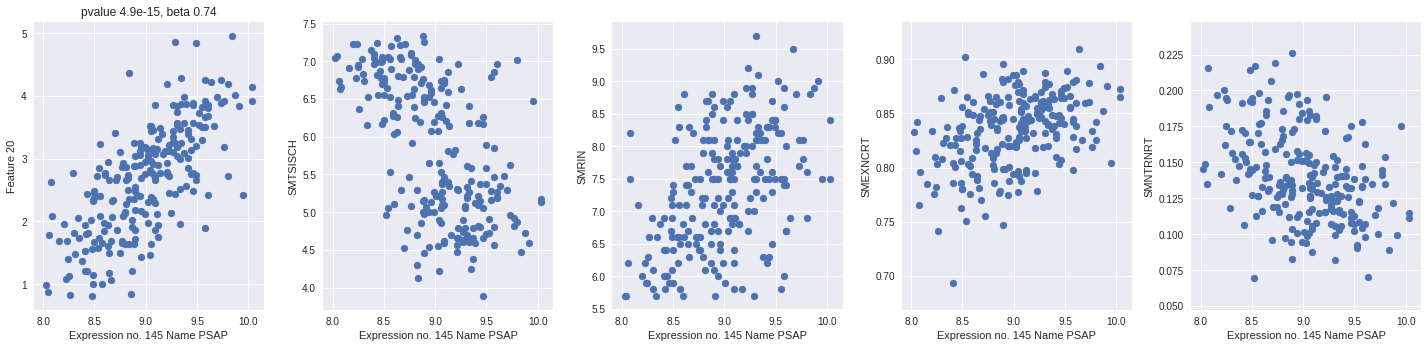

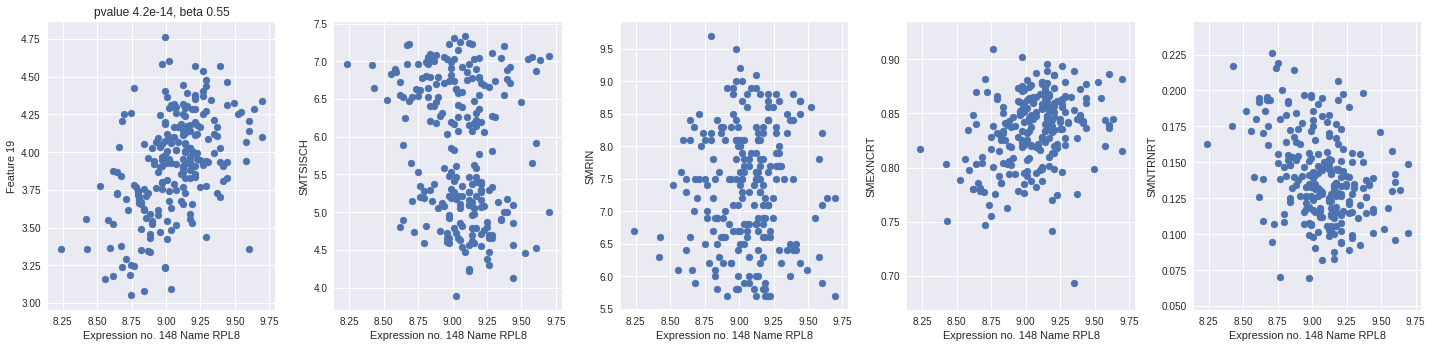

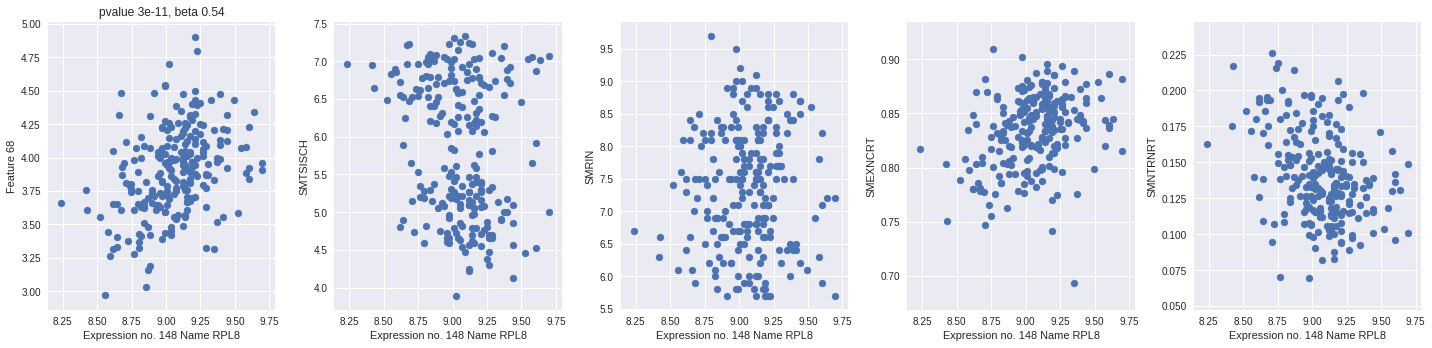

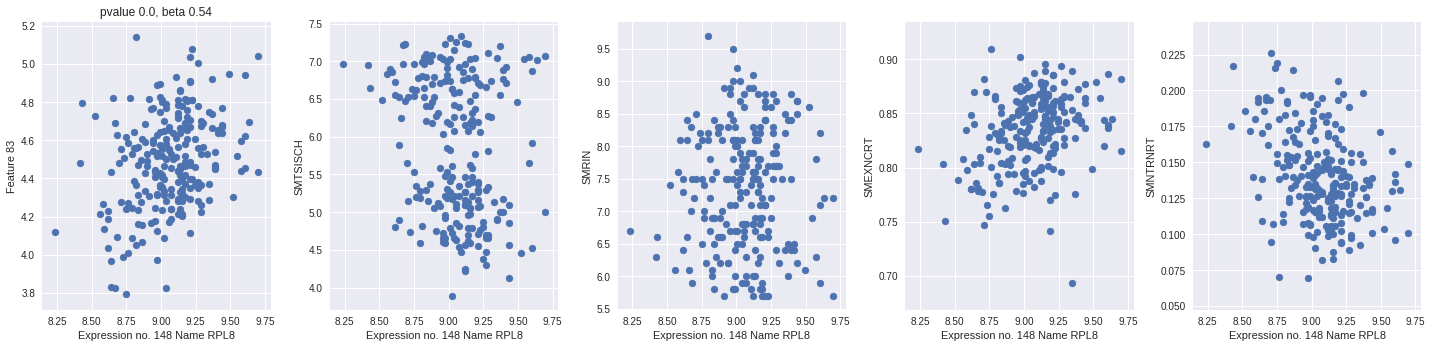

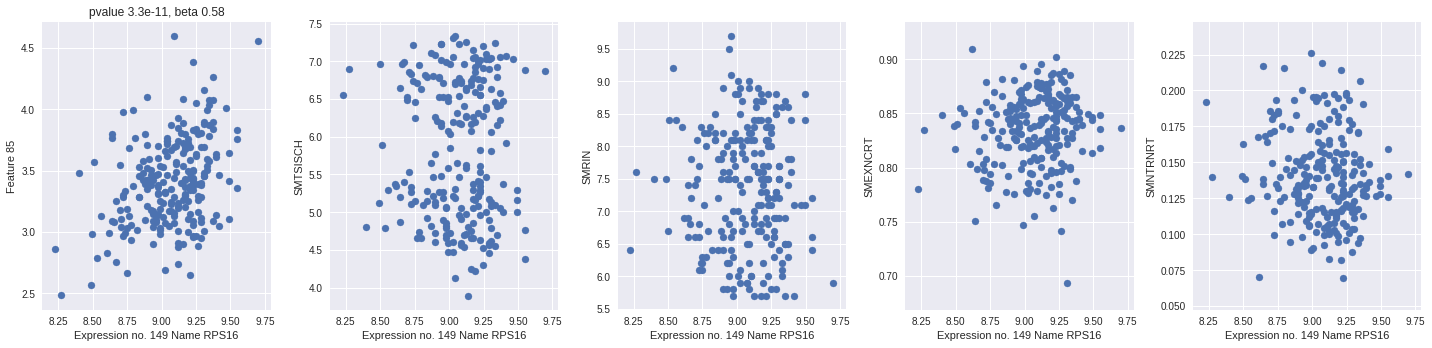

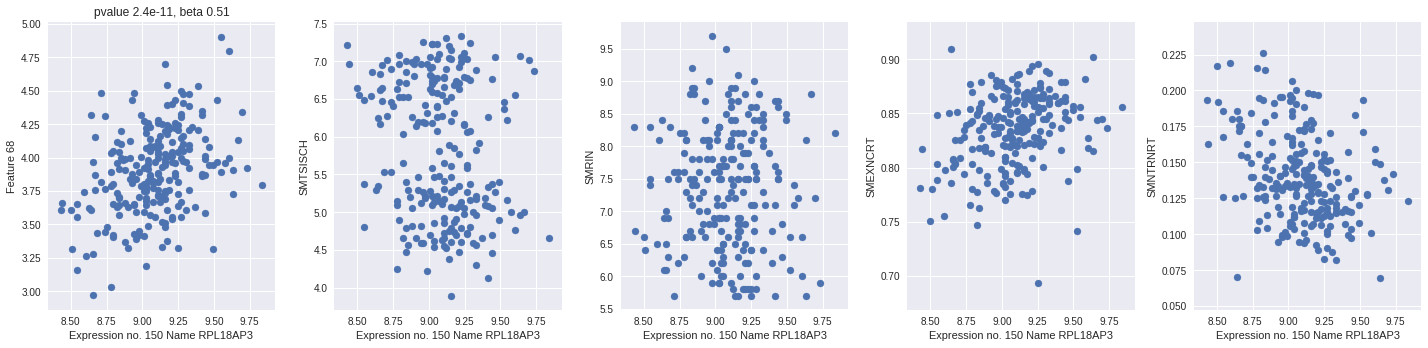

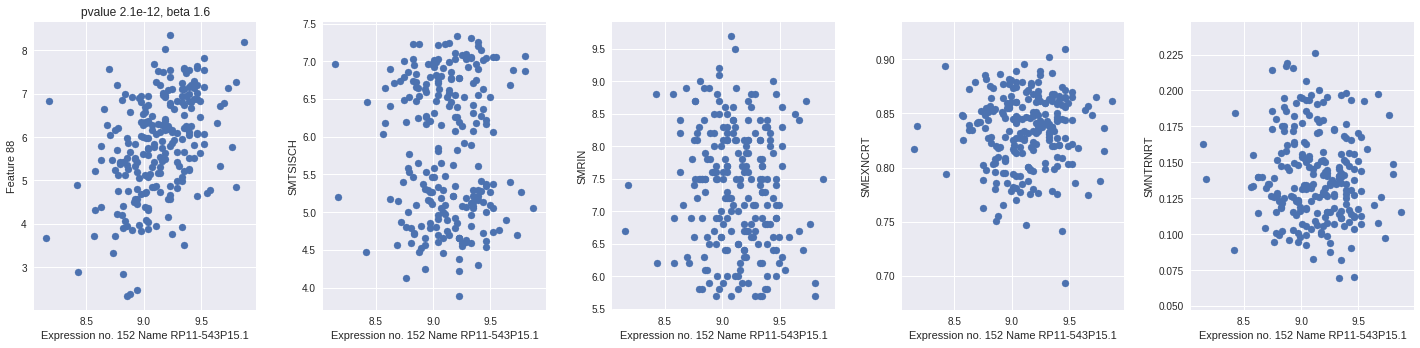

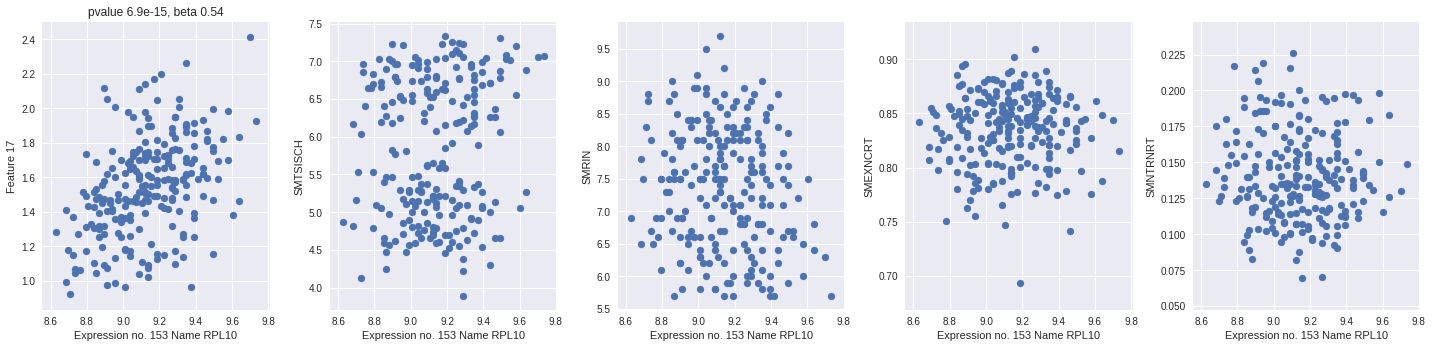

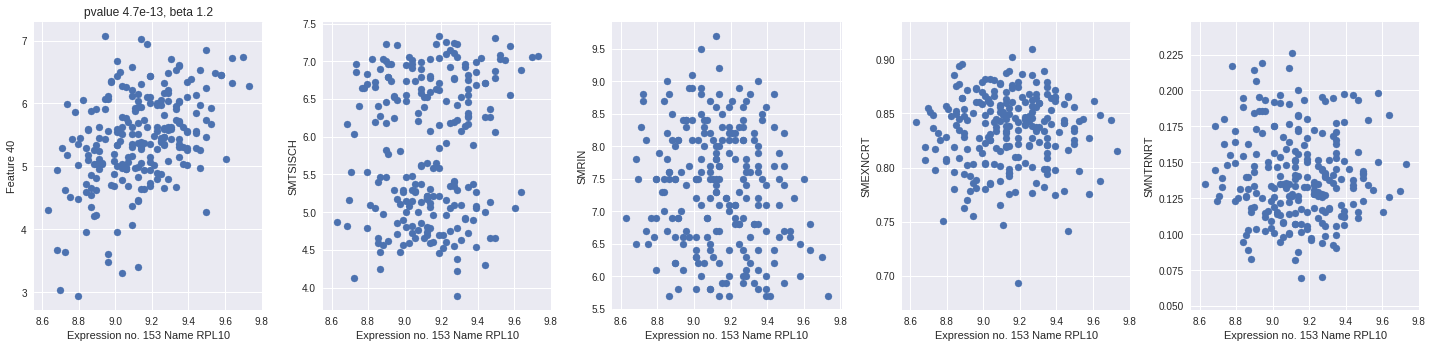

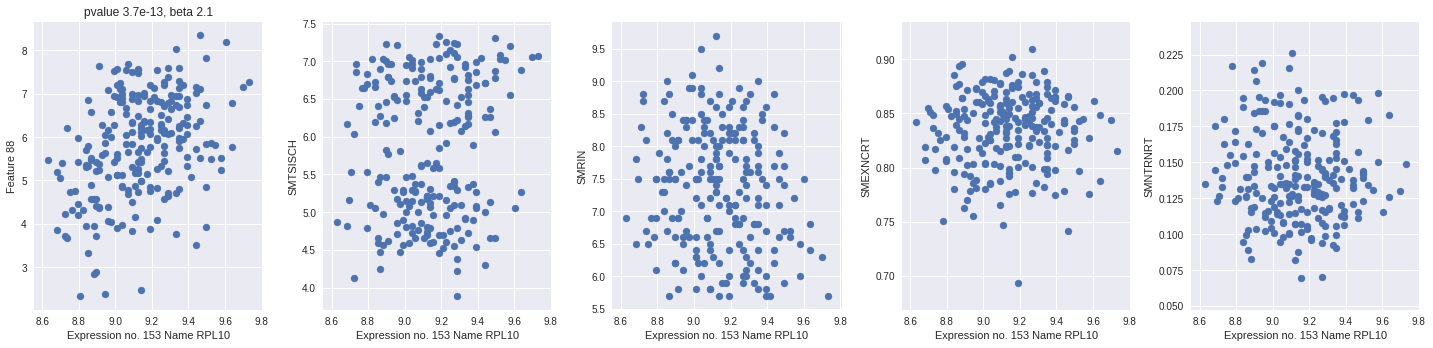

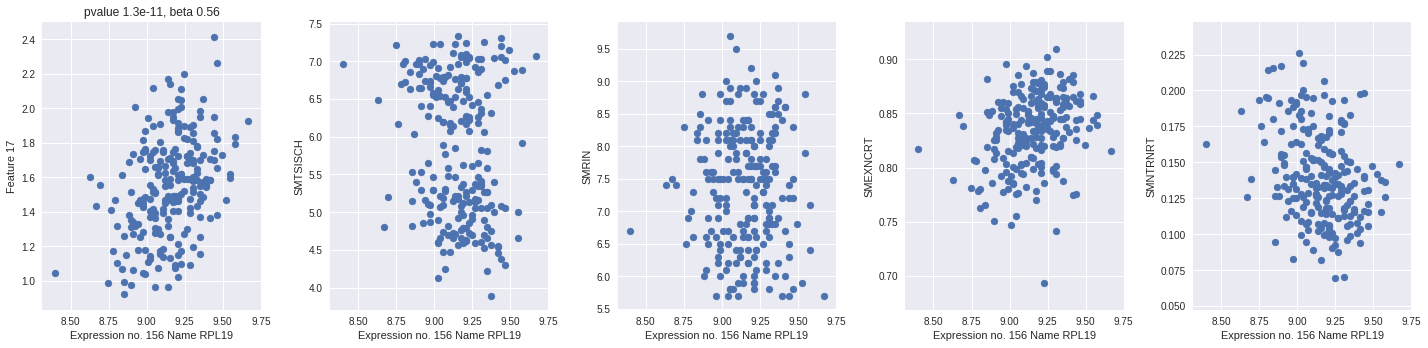

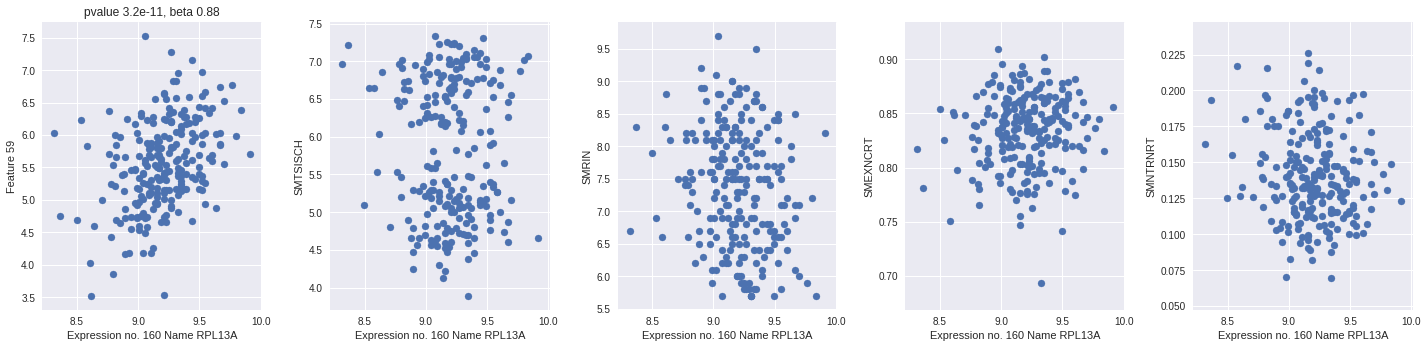

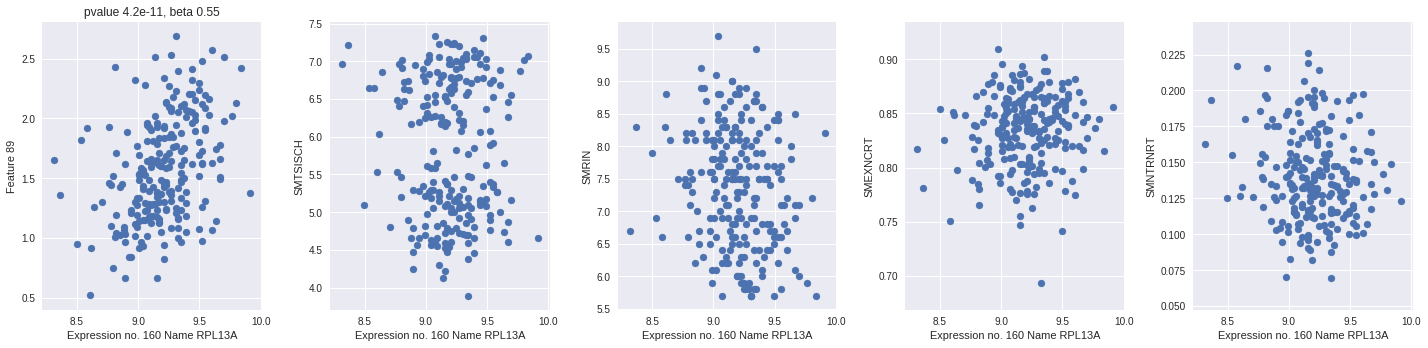

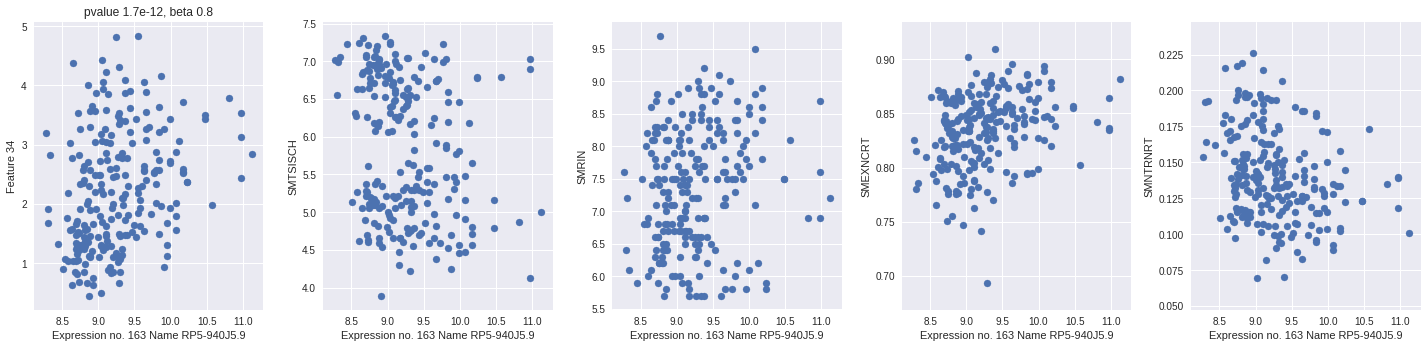

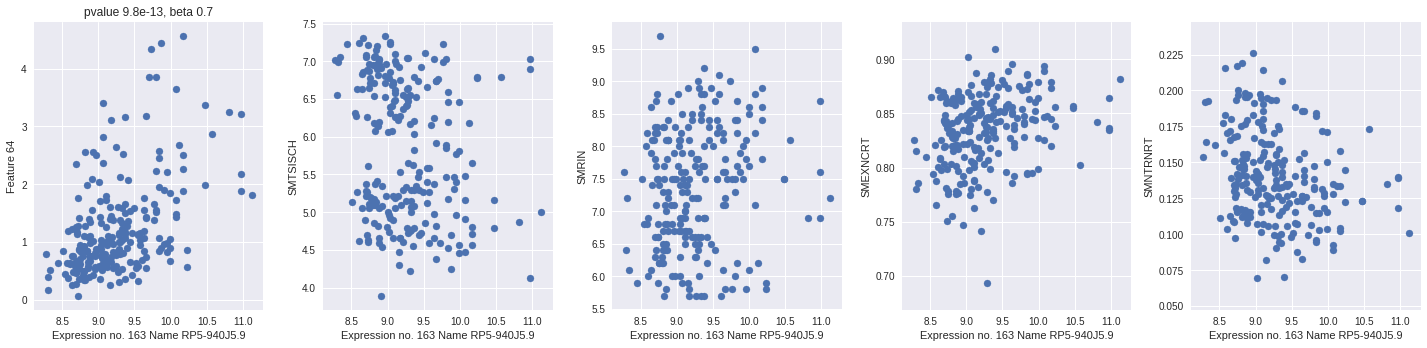

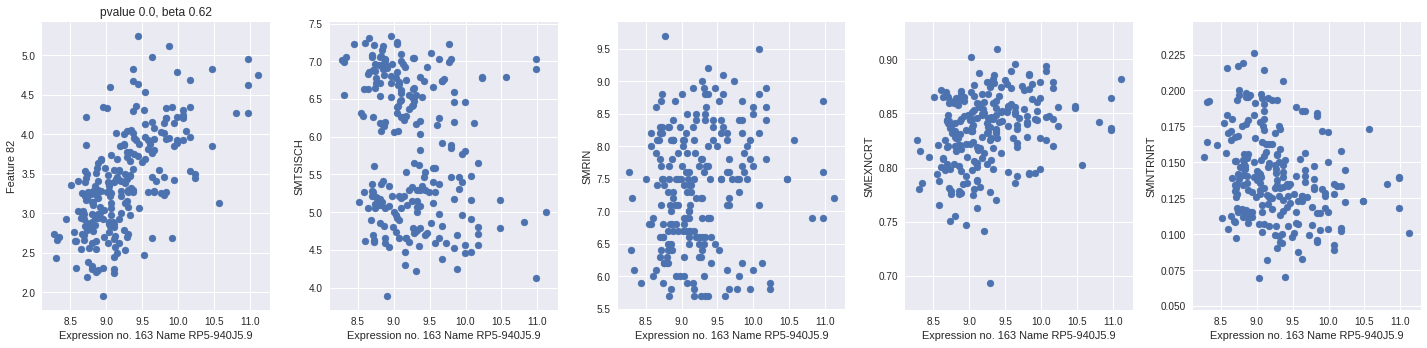

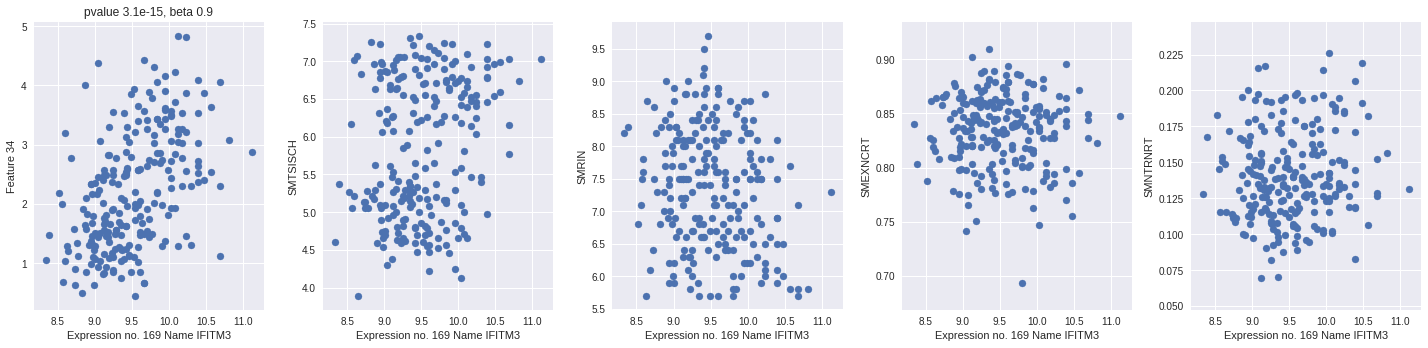

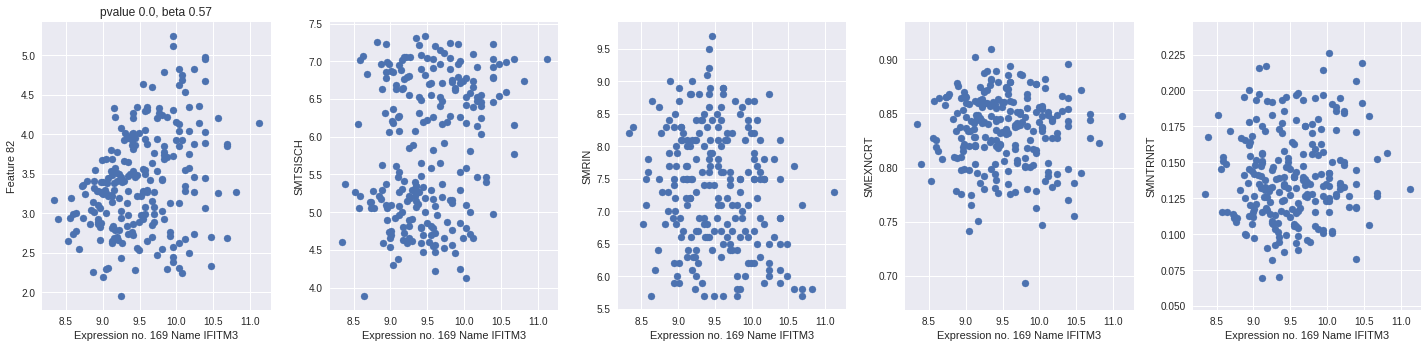

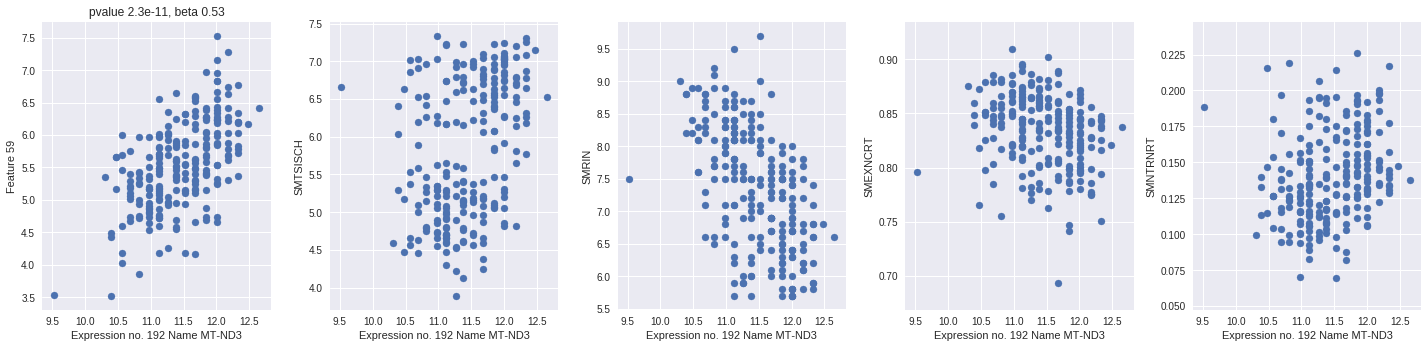

In [466]:
for t in range(200):
    for y in range(100):
        pvalue = results['{}-{}'.format(t,y)].p[-1]
        beta = results['{}-{}'.format(t,y)].coef_[-1]
        if pvalue < 1e-10 and beta > 0.5:
            try:
                display_scatter(t,y)
            except ValueError:
                continue
            

In [463]:
from pyensembl import EnsemblRelease

import pdb
data = EnsemblRelease(77)
def get_gene_name(transcript):
    transcript_id = transcript.decode('utf-8').split('.')[0]
    return data.gene_name_of_gene_id(transcript_id)
    
def display_scatter(t,y):
    fig, ax = plt.subplots(1,5,figsize=(20,5))
    pvalue = results['{}-{}'.format(t,y)].p[-1]
    beta = results['{}-{}'.format(t,y)].coef_[-1]
    
    ax[0].scatter(filt_tech_expression[:,t], filt_tech_features[:,y])
    ax[0].set_title('pvalue {:.2}, beta {:.2}'.format(pvalue,beta))
    ax[0].set_xlabel("Expression no. {} Name {}".format(t, get_gene_name(expression_IDs[most_expressed_transcript_idx][t])))
    ax[0].set_ylabel("Feature {}".format(y))
    
    labels = ['SMTSISCH','SMRIN','SMEXNCRT','SMNTRNRT']
    for k in range(4):    
        ax[k+1].scatter(filt_tech_expression[:,t], filt_raw_technical_covariates[:,k])
        ax[k+1].set_xlabel("Expression no. {} Name {}".format(t, get_gene_name(expression_IDs[most_expressed_transcript_idx][t])))
        ax[k+1].set_ylabel(labels[k])
        
    fig.tight_layout()

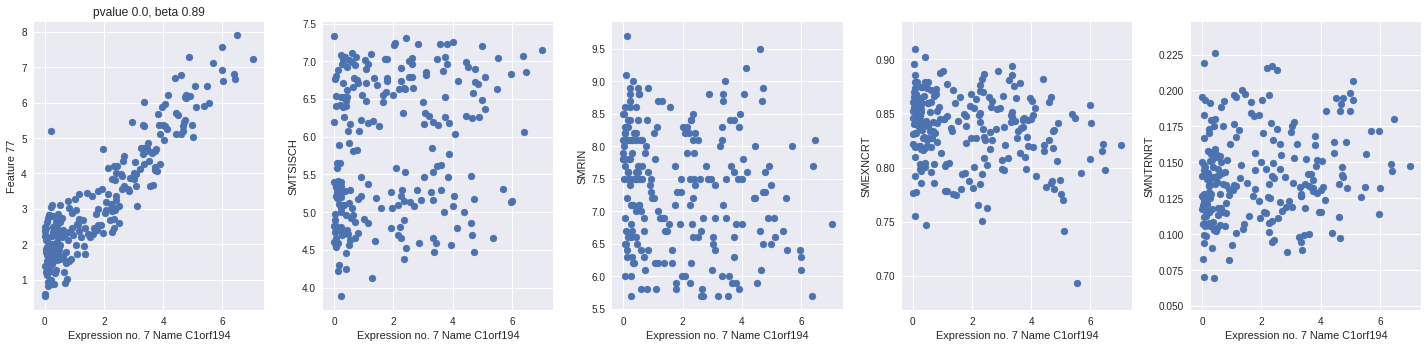

In [464]:
display_scatter(7,77)